## Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime as dat
import pickle
import re
from pathlib import Path

# from google.colab import data_table
# data_table.enable_dataframe_formatter()

# preprocessing tool
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

# modeling tool
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans 
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

font1 = {'family':'serif','color':'blue','size':30}
font2 = {'family':'serif','color':'darkred','size':30}
font2 = {'family':'serif','color':'red','size':30}

In [11]:
# from google.colab import drive 
# from google.colab import data_table
# data_table.enable_dataframe_formatter()  # to enable auto Data table display for Pandas dataframes
# # data_table.disable_dataframe_formatter() # and to disable automatic data table
# drive.mount("/content/drive")


##  read in data

In [5]:
# Unpickle all the file into 
datalist = []
# basepath = '/content/picked/'
# basepath = '/J_data/'
basepath = '../data/large_data/pickled'
for item in sorted(Path(basepath).iterdir()): 
    if item.is_file():  # filter out items that are directories
        with open(item, 'rb') as f:    # file to
          datalist.append(pickle.load(f))

[n.name[0] for n in datalist]   # view the arrangement of the files

['benignprivate',
 'benignpublic_somfylock',
 'ICMPprivate',
 'ICMPpublic',
 'TCPSYNprivate',
 'TCPSYNpublicfiltered',
 'UDPprivate',
 'UDPpublicfiltered']

In [6]:
# read all data
normal_df, public_normal_df, private_ICMP, public_ICMP, tcpsyn_df, public_tcpsyn_df, \
private_UDP, public_UDP = [d for d in datalist]

## HELPER FUNCTIONS 
To extract flow metrics from traffic flow data and for the modeling

In [16]:
def extract_tcp_flag(n):
  pattern = r"\d\[\w*\W*\w*]|\W\[\w*\W*\w*]"
  pattern2 = r"[A-Z]{3}"
  a = ''.join(re.split("\s", n))
  b = re.findall(pattern, a)
  return ''.join(re.findall(pattern2, b[0])) if b else 'NONE'

# TCP SYN tcpsyn

In [28]:
public_tcpsyn_df.head()

,No.,Time,Source,Destination,Protocol,Length,Sequence Number,Info,name
0,2,0.000004,192.168.100.55,192.168.100.3,TCP,1405,1.0,8080 > 80 [<None>] Seq=1 Win=1024 Len=1351,TCPSYNpublicfiltered
1,7,0.003427,192.168.100.5,192.168.100.3,TCP,1216,1.0,0 > 0 [<None>] Seq=1 Win=1024 Len=1162,TCPSYNpublicfiltered
2,10,0.015451,192.168.100.55,192.168.100.3,TCP,890,1.0,[TCP Retransmission] 8080 > 80 [<None>] Seq=...,TCPSYNpublicfiltered
3,14,0.015466,192.168.100.7,192.168.100.3,UDP,60,NaN,365 > 565 Len=18,TCPSYNpublicfiltered
4,17,0.027430,192.168.100.55,192.168.100.3,TCP,1054,1.0,[TCP Retransmission] 8080 > 80 [<None>] Seq=...,TCPSYNpublicfiltered


In [7]:
# normal_df = pd.read_csv('/content/drive/MyDrive/Journal/New project/data/NormalData.csv')
# tcpsyn_df = pd.read_csv('/content/drive/MyDrive/Journal/New project/data/DDoSData.csv')

# normal_df = pd.read_csv('/content/benignprivate.csv')
# tcpsyn_df = pd.read_csv('/content/TCPSYNprivate.csv')
# public_normal_df = pd.read_csv('/content/benignpublic_somfylock.csv')
public_tcpsyn_df = pd.read_csv('../data/public/TCPSYNpublicfiltered.csv')


public_tcpsyn_df = public_tcpsyn_df.loc[public_tcpsyn_df['No.'] >= 34855]     # filter from where the attack started from
public_normal_df =  public_normal_df.loc[public_normal_df['No.'] < 591]     # filter for 1min traffic

public_tcpsyn_df['label'] = 'tcpsyn'
tcpsyn_df['label'] = 'tcpsyn'
normal_df['label'] = 'normal'
public_normal_df['label'] = 'normal'

public_normal_df.tail()

C:\Users\OLUWAS~1.APE\AppData\Local\Temp/ipykernel_3208/1730933731.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  public_normal_df['label'] = 'normal'


,No.,Time,Source,Destination,Protocol,Length,Sequence Number,Info,name,label
140,584,601.024906,18.195.134.106,192.168.1.158,TLSv1.2,123,10432.0,Application Data,benignpublic_somfylock,normal
141,585,601.024908,18.195.134.106,192.168.1.158,TCP,123,10432.0,"[TCP Retransmission] 443 > 10366 [PSH, ACK] ...",benignpublic_somfylock,normal
142,586,601.045382,192.168.1.158,18.195.134.106,TCP,60,3395.0,10366 > 443 [ACK] Seq=3395 Ack=10501 Win=488...,benignpublic_somfylock,normal
143,587,601.045387,192.168.1.158,18.195.134.106,TCP,60,3395.0,[TCP Dup ACK 586#1] 10366 > 443 [ACK] Seq=33...,benignpublic_somfylock,normal
144,590,611.050434,192.168.1.158,18.195.134.106,TLSv1.2,363,3395.0,Application Data,benignpublic_somfylock,normal


In [8]:
# tcpsyn_df
# public_tcpsyn_df.tail()
normal_df.head()
# public_normal_df

,Time,Frame Number,Source,Destination,Protocol,Length,Sequence number,Info,name,label
0,0.000000,1,rcr-663.local,ec2-34-243-56-134.eu-west-1.compute.amazonaws.com,TCP,66,1.0,44420 > https(443) [ACK] Seq=1 Ack=1 Win=631...,benignprivate,normal
1,0.020403,2,ec2-34-243-56-134.eu-west-1.compute.amazonaws.com,rcr-663.local,TCP,66,1.0,[TCP ACKed unseen segment] https(443) > 4442...,benignprivate,normal
2,9.984042,3,rcr-663.local,ec2-34-246-111-38.eu-west-1.compute.amazonaws.com,TCP,66,1.0,57970 > https(443) [ACK] Seq=1 Ack=1 Win=100...,benignprivate,normal
3,10.002878,4,ec2-34-246-111-38.eu-west-1.compute.amazonaws.com,rcr-663.local,TCP,66,1.0,[TCP ACKed unseen segment] https(443) > 5797...,benignprivate,normal
4,14.778480,5,rcr-663.local,ec2-34-246-111-38.eu-west-1.compute.amazonaws.com,TLSv1.2,97,2.0,"[TCP Previous segment not captured] , Applicat...",benignprivate,normal


## data preprocessing

In [9]:
public_tcpsyn_first50 = public_tcpsyn_df[:50]#.reset_index(drop=True)
public_tcpsyn_last50 = public_tcpsyn_df[-50:]#.reset_index(drop=True)
public_tcpsyn_first50.head()
public_tcpsyn_last50.tail()

public_normal_df

,No.,Time,Source,Destination,Protocol,Length,Sequence Number,Info,name,label
0,332,546.263114,192.168.1.1,192.168.1.158,DHCP,342,NaN,DHCP Offer - Transaction ID 0xabcd0001,benignpublic_somfylock,normal
1,333,546.263121,192.168.1.1,192.168.1.158,DHCP,342,NaN,DHCP Offer - Transaction ID 0xabcd0001,benignpublic_somfylock,normal
2,351,547.061661,192.168.1.1,192.168.1.158,DHCP,342,NaN,DHCP Offer - Transaction ID 0xabcd0001,benignpublic_somfylock,normal
3,352,547.061667,192.168.1.1,192.168.1.158,DHCP,342,NaN,DHCP Offer - Transaction ID 0xabcd0001,benignpublic_somfylock,normal
4,359,547.092639,192.168.1.1,192.168.1.158,DHCP,342,NaN,DHCP ACK - Transaction ID 0xabcd0001,benignpublic_somfylock,normal
...,...,...,...,...,...,...,...,...,...,...
140,584,601.024906,18.195.134.106,192.168.1.158,TLSv1.2,123,10432.0,Application Data,benignpublic_somfylock,normal
141,585,601.024908,18.195.134.106,192.168.1.158,TCP,123,10432.0,"[TCP Retransmission] 443 > 10366 [PSH, ACK] ...",benignpublic_somfylock,normal
142,586,601.045382,192.168.1.158,18.195.134.106,TCP,60,3395.0,10366 > 443 [ACK] Seq=3395 Ack=10501 Win=488...,benignpublic_somfylock,normal
143,587,601.045387,192.168.1.158,18.195.134.106,TCP,60,3395.0,[TCP Dup ACK 586#1] 10366 > 443 [ACK] Seq=33...,benignpublic_somfylock,normal


In [10]:
# filter fpr 1 minute  data
tcpsyn_df1 = tcpsyn_df[326:8571].reset_index(drop=True)
tcpsyn_df1 = tcpsyn_df1[tcpsyn_df1.loc[:,'Protocol'] != 'ICMP'] # filter out ICMP traffic

normal_df1 = normal_df[37:101].reset_index(drop=True)

tcpsyn_df1

,Time,Frame Number,Source,Destination,Protocol,Length,Sequence number,Info,name,label
0,18.193597,327,192.168.0.103,192.168.0.100,TCP,62,0,62347 > 36044 [SYN] Seq=0 Win=65535 Len=0 MS...,TCPSYNprivate,tcpsyn
1,18.193600,328,192.168.0.103,192.168.0.100,TCP,62,0,62346 > 36044 [SYN] Seq=0 Win=65535 Len=0 MS...,TCPSYNprivate,tcpsyn
2,18.373583,329,192.168.0.103,192.168.0.100,TCP,62,0,62348 > 36044 [SYN] Seq=0 Win=65535 Len=0 MS...,TCPSYNprivate,tcpsyn
3,18.390793,330,192.168.0.103,192.168.0.100,TCP,78,0,62501 > 36044 [SYN] Seq=0 Win=65535 Len=0 MS...,TCPSYNprivate,tcpsyn
4,18.390796,331,192.168.0.103,192.168.0.100,TCP,78,0,62502 > 36044 [SYN] Seq=0 Win=65535 Len=0 MS...,TCPSYNprivate,tcpsyn
...,...,...,...,...,...,...,...,...,...,...
8239,77.609171,8566,192.168.0.103,192.168.0.100,TCP,78,0,[TCP Retransmission] 62823 > 36044 [SYN] Seq...,TCPSYNprivate,tcpsyn
8240,77.627373,8567,192.168.0.103,192.168.0.100,TCP,78,0,[TCP Retransmission] 62818 > 36044 [SYN] Seq...,TCPSYNprivate,tcpsyn
8241,77.661527,8568,192.168.0.103,192.168.0.100,TCP,78,0,[TCP Retransmission] 62828 > 36044 [SYN] Seq...,TCPSYNprivate,tcpsyn
8242,77.661529,8569,192.168.0.103,192.168.0.100,TCP,78,0,[TCP Retransmission] 62832 > 36044 [SYN] Seq...,TCPSYNprivate,tcpsyn


## TCP Counts

In [11]:
# private
# tcp private (1 minute data)
# normal
bool1 = normal_df1.loc[:,'Protocol'] == 'TCP'
normal_tcp = normal_df1[bool1]
normal_tcp.head(5)

# tcpsyn
# print(tcpsyn_df1)
bool2 = tcpsyn_df1.loc[:,'Protocol'] == 'TCP'
tcpsyn_tcp = tcpsyn_df1[bool2]
tcpsyn_tcp.head(5)

# public
# normal
bool3 = public_normal_df.loc[:,'Protocol'] == 'TCP'
public_tcpsyn_tcp = public_normal_df[bool3]
public_tcpsyn_tcp.head(5)

# tcpsyn
bool4 = public_tcpsyn_df.loc[:,'Protocol'] == 'TCP'
public_normal_tcp = public_tcpsyn_df[bool4]
public_normal_tcp.head(5)

,No.,Time,Source,Destination,Protocol,Length,Sequence Number,Info,label
11547,34855,58.222091,192.168.100.147,192.168.100.3,TCP,154,0.0,1127 > 80 [SYN] Seq=0 Win=512 Len=100 [TCP s...,tcpsyn
11548,34856,58.222167,192.168.100.147,192.168.100.3,TCP,154,0.0,1130 > 80 [SYN] Seq=0 Win=512 Len=100 [TCP s...,tcpsyn
11549,34857,58.222169,192.168.100.147,192.168.100.3,TCP,154,0.0,1131 > 80 [SYN] Seq=0 Win=512 Len=100 [TCP s...,tcpsyn
11550,34858,58.222170,192.168.100.147,192.168.100.3,TCP,154,0.0,1134 > 80 [SYN] Seq=0 Win=512 Len=100 [TCP s...,tcpsyn
11551,34859,58.222172,192.168.100.147,192.168.100.3,TCP,154,0.0,1135 > 80 [SYN] Seq=0 Win=512 Len=100 [TCP s...,tcpsyn


In [12]:
# public_tcpsyn_first50 = public_tcpsyn_df[:50]#.reset_index(drop=True)
# public_tcpsyn_last50 = public_tcpsyn_df[-50:]#.reset_index(drop=True)
# public_tcpsyn_first50
# public_tcpsyn_last50

# public_normal_df

# # public
# # tcp private (1 minute data)
# # normal
# bool1 = public_normal_df.loc[:,'Protocol'] == 'TCP'
# p_normal_tcp = public_normal_df[bool1]
# # p_normal_tcp.head(5)

# # tcpsyn
# # print(tcpsyn_df1)
# bool2 = public_tcpsyn_df.loc[:,'Protocol'] == 'TCP'
# p_tcpsyn_tcp = public_tcpsyn_df[bool2]
# # p_tcpsyn_tcp.head(5)

# # tcp public
# # normal
# bool3 = public_normal_df.loc[:,'Protocol'] == 'TCP'
# public_tcpsyn_tcp = public_normal_df[bool3]
# public_tcpsyn_tcp.head(5)

# # tcpsyn
# bool4 = public_tcpsyn_df.loc[:,'Protocol'] == 'TCP'
# public_normal_tcp = public_tcpsyn_df[bool4]
# public_normal_tcp.head(5)

##### Private

tcp counts:
label
normal      41
tcpsyn    7976
Name: Frame Number, dtype: int64


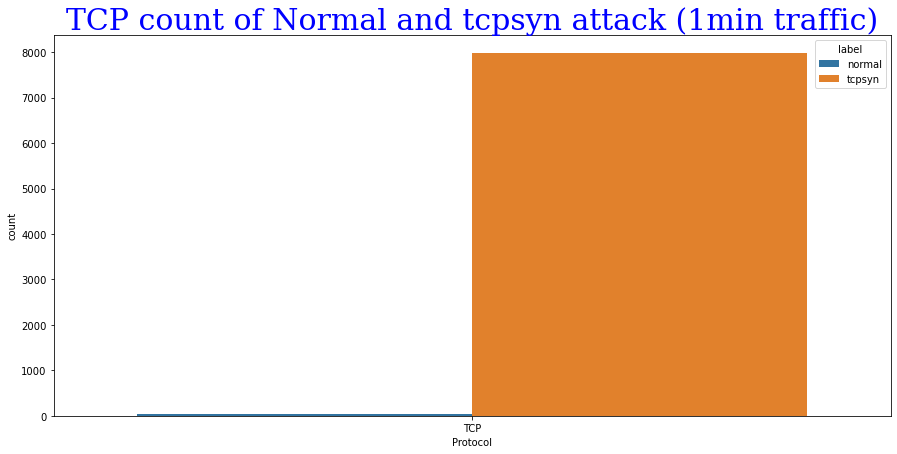

In [13]:
# combine the tcpsyn tcpsyn data to the normal data (private)
tcps = pd.concat([normal_tcp, tcpsyn_tcp]).reset_index(drop=True)

print('tcp counts:')
print(tcps.groupby('label')['Frame Number'].count())

# plot tcp counts in 1 minute packet flow
plt.figure(figsize=(15,7))
sns.countplot(x='Protocol', hue='label', data=tcps)
plt.title("TCP count of Normal and tcpsyn attack (1min traffic)", fontdict = font1)
plt.show()

#####  Public

tcp counts:
label
normal         95
tcpsyn    1152428
Name: No., dtype: int64


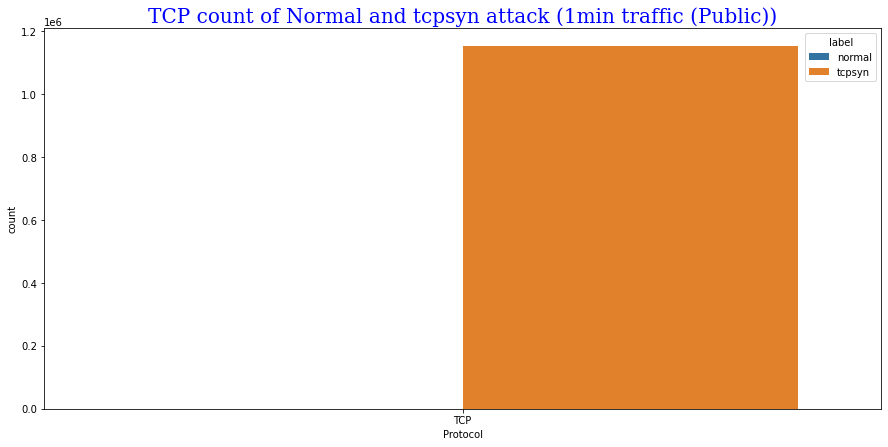

In [17]:
# combine the tcpsyn tcpsyn data to the normal data
tcps_public = pd.concat([public_tcpsyn_tcp, public_normal_tcp]).reset_index(drop=True)

print('tcp counts:')
print(tcps_public.groupby('label')['No.'].count())

# plot tcp counts in 1 minute packet flow
plt.figure(figsize=(15,7))
sns.countplot(x='Protocol', hue='label', data=tcps_public)
plt.title("TCP count of Normal and tcpsyn attack (1min traffic (Public))", fontdict = font1)
plt.show()

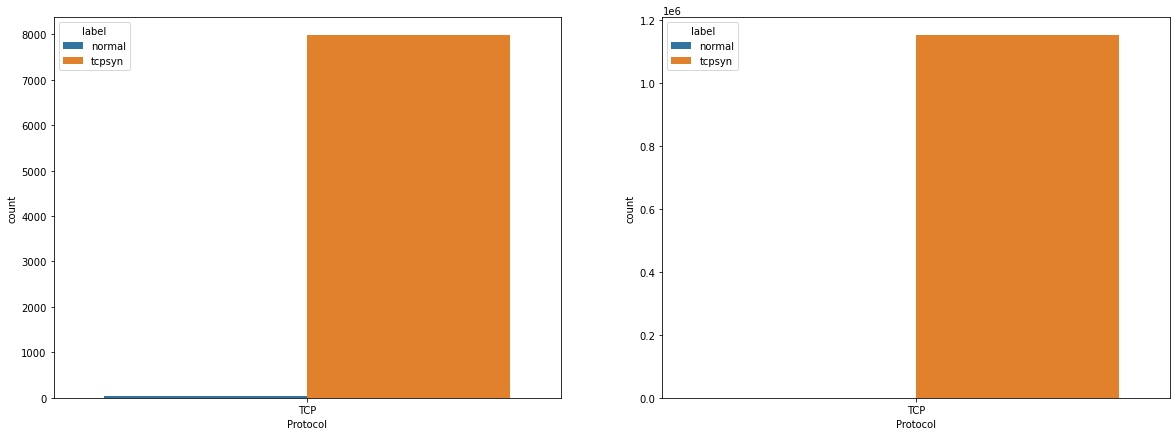

In [40]:
# tcps_public['grouplabel'] = 'public'
# tcps['grouplabel'] = 'private'

# joined_tcps = pd.concat([tcps, tcps_public]).reset_index(drop=True)

# plt.figure(figsize=(15,7))
# sns.countplot(x='grouplabel', 
#               hue='label',
#               data=joined_tcps)
# plt.title("TCP count of Normal and tcpsyn attack (1min traffic)", fontdict = font1)
# plt.show()


fig, ax = plt.subplots(1, 2, figsize=(20,7))
# plot tcp counts in 1 minute packet flow
sns.countplot(x='Protocol', hue='label', data=tcps, ax=ax[0])
# plt.title("TCP count of Normal and tcpsyn attack (1min traffic)", fontdict = font1)

sns.countplot(x='Protocol', hue='label', data=tcps_public, ax=ax[1])
# plt.title("TCP count of Normal and tcpsyn attack (1min traffic (Public))", fontdict = font1)
plt.show()

## variations

### Packet length variation

In [107]:
# MinMax Scaling
# normal_df1.loc[:,['Length']].apply(lambda x: (x-x.min())/(x.max() - x.min()), axis=0)
# private data
normal_df1['Length'] = MinMaxScaler().fit_transform(normal_df1.loc[:,['Length']])
tcpsyn_df1['Length'] = MinMaxScaler().fit_transform(tcpsyn_df1.loc[:,['Length']])

# public data
public_normal_df['Length'] = MinMaxScaler().fit_transform(public_normal_df.loc[:,['Length']])
public_tcpsyn_df['Length'] = MinMaxScaler().fit_transform(public_tcpsyn_df.loc[:,['Length']])

C:\Users\OLUWAS~1.APE\AppData\Local\Temp/ipykernel_17048/242496915.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  public_normal_df['Length'] = MinMaxScaler().fit_transform(public_normal_df.loc[:,['Length']])


##### private

Text(0.5, 1.0, 'tcpsyn attack Packet length Variation (all packets - 1min traffic)')

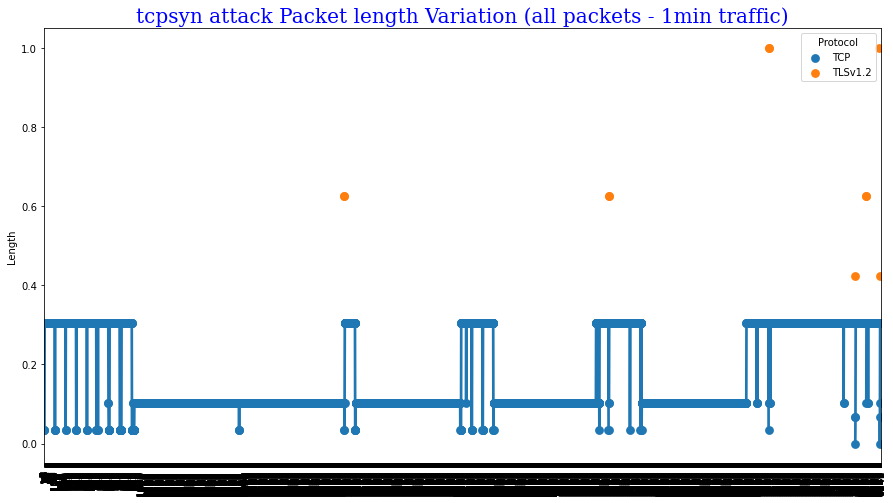

In [42]:
# tcpsyn tcpsyn data (all packets)
plt.figure(figsize = (15,8))
sns.pointplot(x=tcpsyn_df1.index, y='Length',
              hue='Protocol', 
              data=tcpsyn_df1
              )
plt.xticks(rotation=90)
plt.title("tcpsyn attack Packet length Variation (all packets - 1min traffic)", fontdict = font1)

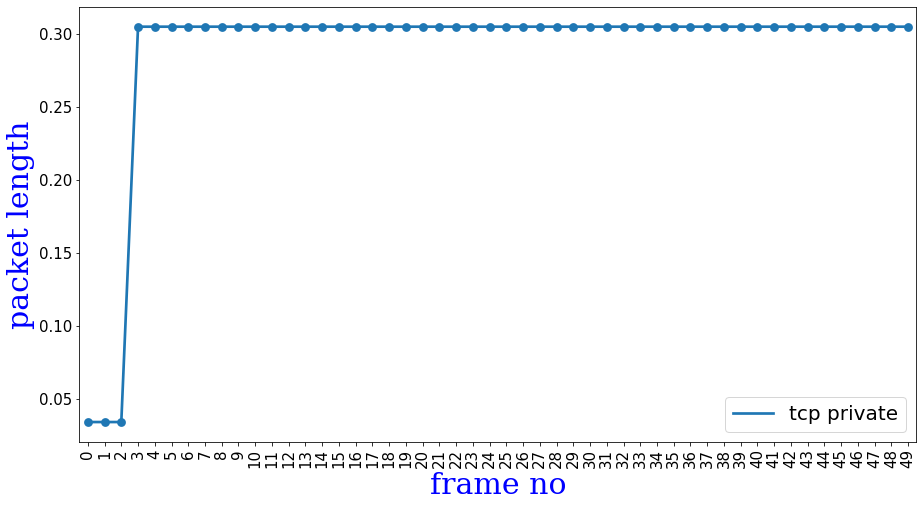

In [114]:
# tcpsyn tcpsyn data (first 50 packets)
plt.figure(figsize = (15,8))
sns.pointplot(x=tcpsyn_df1[:50].index, y='Length',
              hue='Protocol', 
              data=tcpsyn_df1[:50]
              )
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('packet length', fontdict = font1)
plt.xlabel('frame no', fontdict = font1)
plt.legend(['tcp private'], prop={"size":20})
# plt.title("tcpsyn tcpsyn Packet length Variation (first 50 packets - 1min traffic)", fontdict = font1)

# tcpsyn tcpsyn data (last 50 packets)
# plt.figure(figsize = (15,8))
# sns.pointplot(x=tcpsyn_df1[-50:].index, y='Length',
#               hue='Protocol', 
#               data=tcpsyn_df1[-50:]
#               )
# plt.xticks(rotation=90)
# plt.xticks(rotation=90)
# plt.title("tcpsyn tcpsyn Packet length Variation (last 50 packets - 1min traffic)", fontdict = font1)

# # Normal data 
# plt.figure(figsize = (15,8))
# sns.pointplot(x=normal_df1.index, y='Length',
#               hue='Protocol', 
#               data=normal_df1)
# plt.xticks(rotation=90)
# plt.xticks(rotation=90)
# plt.title("Normal Packet Length Variation (all packets - 1min traffic)", fontdict = font1)

##### public

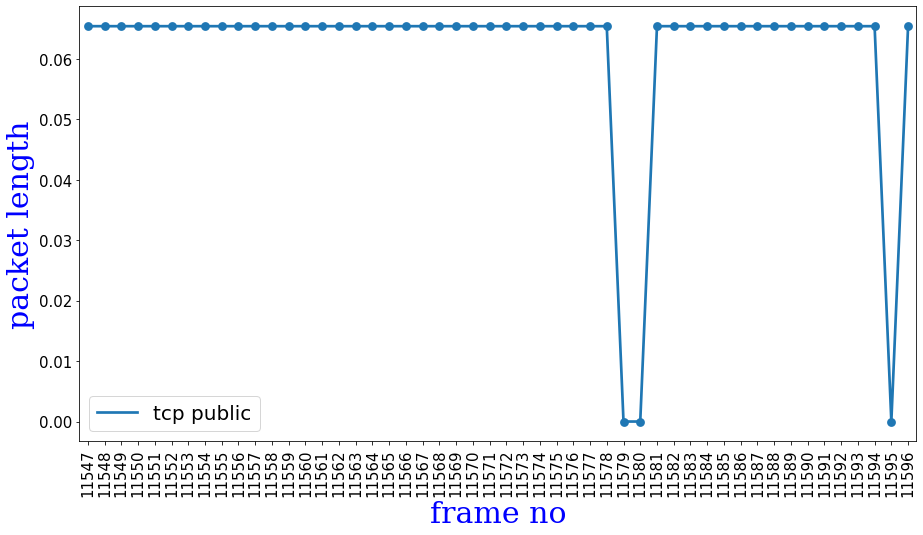

In [113]:
# tcpsyn tcpsyn data (first 50 packets)
plt.figure(figsize = (15,8))
sns.pointplot(x=public_tcpsyn_df[:50].index, y='Length',
              hue='Protocol', 
              data=public_tcpsyn_df[:50]
              )
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('packet length', fontdict = font1)
plt.xlabel('frame no', fontdict = font1)
plt.legend(['tcp public'], prop={"size":20})
# plt.title("tcpsyn attack Packet length Variation (first 50 packets - 1min traffic [Public])", fontdict = font1)

# # tcpsyn tcpsyn data (last 50 packets)
# plt.figure(figsize = (15,8))
# sns.pointplot(x=public_tcpsyn_df[-50:].index, y='Length',
#               hue='Protocol', 
#               data=public_tcpsyn_df[-50:]
#               )
# plt.xticks(rotation=90)
# plt.xticks(rotation=90)
# plt.title("tcpsyn attack Packet length Variation (last 50 packets - 1min traffic [Public])", fontdict = font1)

# # Normal data 
# plt.figure(figsize = (15,8))
# sns.pointplot(x=public_normal_df.index, y='Length',
#               hue='Protocol', 
#               data=public_normal_df)
# plt.xticks(rotation=90)
# plt.xticks(rotation=90)
# plt.title("Normal Packet Length Variation (all packets - 1min traffic [Public])", fontdict = font1)

### protocol variation

##### private

In [50]:
# preprocess
normal_protocols = {q:p for p,q in enumerate(sorted(set(normal_df1.Protocol)))}
tcpsyn_protocols = {q:p for p,q in enumerate(sorted(set(tcpsyn_df1.Protocol)))}
print('Normal data encoding:', normal_protocols)
print('tcpsyn tcpsyn encoding:', tcpsyn_protocols)
new_normal_df1 = normal_df1.copy() # create a new data because of the label encoding
new_tcpsyn_df1 = tcpsyn_df1.copy() # create a new data because of the label encoding
new_normal_df1.Protocol = LabelEncoder().fit_transform(new_normal_df1.Protocol) 
new_tcpsyn_df1.Protocol = LabelEncoder().fit_transform(new_tcpsyn_df1.Protocol)

# # tcpsyn tcpsyn (all packets)
# plt.figure(figsize = (15,8))
# g = sns.pointplot(x=new_tcpsyn_df1.index, y='Protocol',
#               hue='Protocol', 
#               data=new_tcpsyn_df1
#               )
# plt.xticks(rotation=90)
# plt.title("tcpsyn tcpsyn Protocol Variation (all packets - 1min traffic)", fontdict = font1)
# # rename the legend
# current_handles, current_labels = plt.gca().get_legend_handles_labels()
# new_labels = [sorted(set(tcpsyn_df1.Protocol))[int(i)] for i in current_labels]  # recode the protocol label
# plt.legend(current_handles, new_labels)  # call plt.legend() with the new values

Normal data encoding: {'DNS': 0, 'MDNS': 1, 'TCP': 2, 'TLSv1.2': 3}
tcpsyn tcpsyn encoding: {'TCP': 0, 'TLSv1.2': 1}


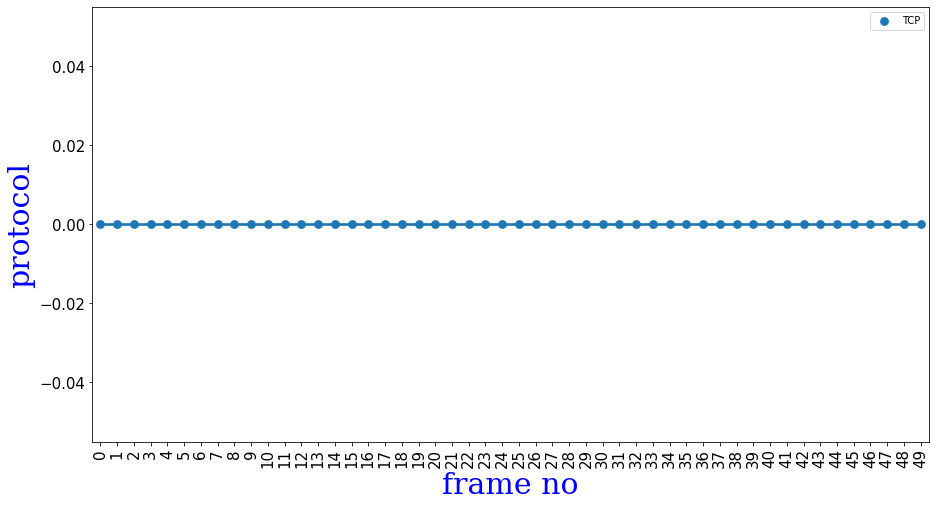

In [121]:
# tcpsyn tcpsyn (first 50 packets)
plt.figure(figsize = (15,8))
g = sns.pointplot(x=new_tcpsyn_df1.index[:50], y='Protocol',
              hue='Protocol', 
              data=new_tcpsyn_df1[:50]
              )
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('protocol', fontdict = font1)
plt.xlabel('frame no', fontdict = font1)
plt.legend(['tcp private'], prop={"size":20})
# plt.title("tcpsyn tcpsyn Protocal Variation (first 50 packets - 1min traffic)", fontdict = font1)
# rename the legend
current_handles, current_labels = plt.gca().get_legend_handles_labels()
new_labels = [sorted(set(tcpsyn_df1.Protocol))[int(i)] for i in current_labels]  # recode the protocol label
plt.legend(current_handles, new_labels)  # call plt.legend() with the new values

# # tcpsyn tcpsyn (last 50 packets)
# plt.figure(figsize = (15,8))
# g = sns.pointplot(x=new_tcpsyn_df1.index[-50:], y='Protocol',
#               hue='Protocol', 
#               data=new_tcpsyn_df1[-50:]
#               )
# plt.xticks(rotation=90)
# plt.title("tcpsyn tcpsyn Protocal Variation (last 50 packets - 1min traffic)", fontdict = font1)
# # rename the legend
# current_handles, current_labels = plt.gca().get_legend_handles_labels()
# new_labels = [sorted(set(tcpsyn_df1.Protocol))[int(i)] for i in current_labels]  # recode the protocol label
# plt.legend(current_handles, new_labels)  # call plt.legend() with the new values

# # normal (all packets)
# plt.figure(figsize = (15,8))
# g = sns.pointplot(x=new_normal_df1.index, y='Protocol',
#               hue='Protocol',          
#               data=new_normal_df1,
#               facet_kws={'legend_out': True} # to make the legend available through the g._legend 
#               )
# plt.xticks(rotation=90)
# plt.title("Normal Protocal Variation (all packets - 1min traffic)", fontdict = font1)
# # rename the legend
# current_handles, current_labels = plt.gca().get_legend_handles_labels()
# new_labels = [sorted(set(normal_df1.Protocol))[int(i)] for i in current_labels]  # recode the protocol label
# plt.legend(current_handles, new_labels)  # call plt.legend() with the new values

##### public

Normal data encoding: {'DHCP': 0, 'DNS': 1, 'ICMP': 2, 'IGMPv2': 3, 'NTP': 4, 'TCP': 5, 'TLSv1.2': 6}
tcpsyn tcpsyn encoding: {'TCP': 0, 'UDP': 1}


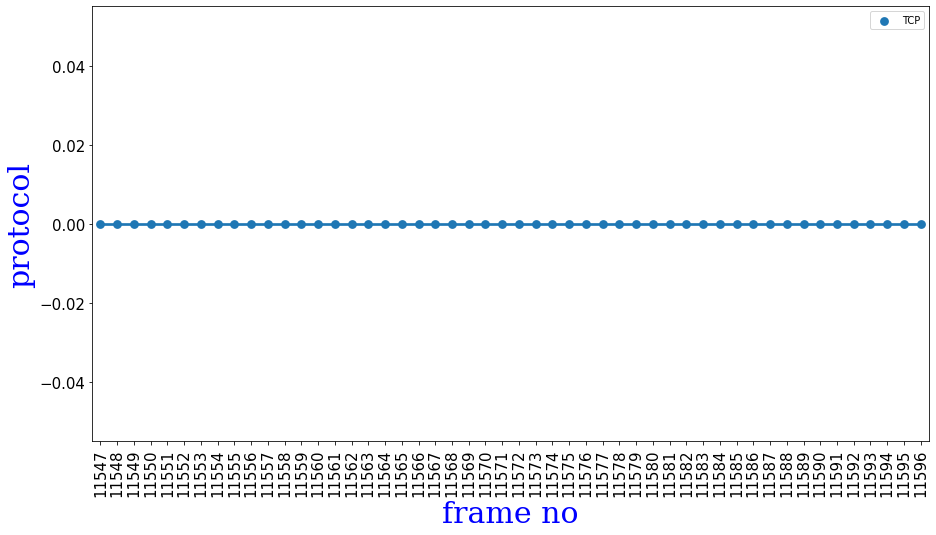

In [123]:
# preprocess
public_normal_protocols = {q:p for p,q in enumerate(sorted(set(public_normal_df.Protocol)))}
public_tcpsyn_protocols = {q:p for p,q in enumerate(sorted(set(public_tcpsyn_df.Protocol)))}
print('Normal data encoding:', public_normal_protocols)
print('tcpsyn tcpsyn encoding:', public_tcpsyn_protocols)
new_Pnormal_df1 = public_normal_df.copy() # create a new data because of the label encoding
new_Ptcpsyn_df1 = public_tcpsyn_df.copy() # create a new data because of the label encoding
new_Pnormal_df1.Protocol = LabelEncoder().fit_transform(new_Pnormal_df1.Protocol) 
new_Ptcpsyn_df1.Protocol = LabelEncoder().fit_transform(new_Ptcpsyn_df1.Protocol)

# tcpsyn tcpsyn (first 50 packets)
plt.figure(figsize = (15,8))
g = sns.pointplot(x=new_Ptcpsyn_df1.index[:50], y='Protocol',
              hue='Protocol', 
              data=new_Ptcpsyn_df1[:50]
              )
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('protocol', fontdict = font1)
plt.xlabel('frame no', fontdict = font1)
plt.legend(['tcp private'], prop={"size":20})
# plt.title("tcpsyn attack Protocal Variation (first 50 packets - 1min traffic (Public))", fontdict = font1)
# rename the legend
current_handles, current_labels = plt.gca().get_legend_handles_labels()
new_labels = [sorted(set(public_tcpsyn_df.Protocol))[int(i)] for i in current_labels]  # recode the protocol label
plt.legend(current_handles, new_labels)  # call plt.legend() with the new values

# # tcpsyn tcpsyn (last 50 packets)
# plt.figure(figsize = (15,8))
# g = sns.pointplot(x=new_Ptcpsyn_df1.index[-50:], y='Protocol',
#               hue='Protocol', 
#               data=new_Ptcpsyn_df1[-50:]
#               )
# plt.xticks(rotation=90)
# plt.title("tcpsyn attack Protocal Variation (last 50 packets - 1min traffic (Public))", fontdict = font1)
# # rename the legend
# current_handles, current_labels = plt.gca().get_legend_handles_labels()
# new_labels = [sorted(set(public_tcpsyn_df.Protocol))[int(i)] for i in current_labels]  # recode the protocol label
# plt.legend(current_handles, new_labels)  # call plt.legend() with the new values

# # normal (all packets)
# plt.figure(figsize = (15,8))
# g = sns.pointplot(x=new_Pnormal_df1.index, y='Protocol',
#               hue='Protocol',          
#               data=new_Pnormal_df1,
#               facet_kws={'legend_out': True} # to make the legend available through the g._legend 
#               )
# plt.xticks(rotation=90)
# plt.title("Normal Protocal Variation (all packets - 1min traffic (Public))", fontdict = font1)
# # rename the legend
# current_handles, current_labels = plt.gca().get_legend_handles_labels()
# new_labels = [sorted(set(public_normal_df.Protocol))[int(i)] for i in current_labels]  # recode the protocol label
# plt.legend(current_handles, new_labels)  # call plt.legend() with the new values

AttributeError: 'AxesSubplot' object has no attribute 'set_gca'

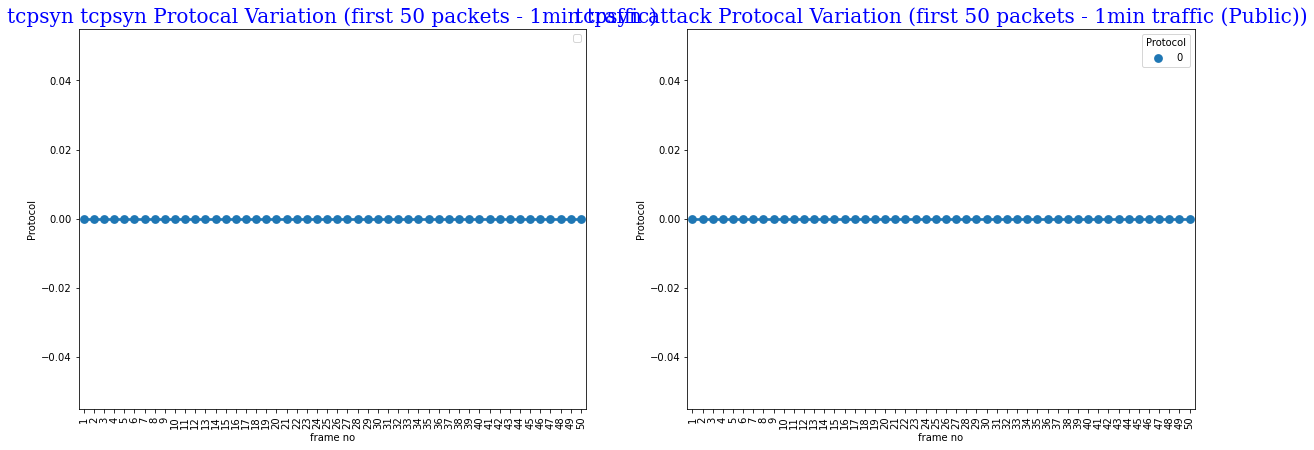

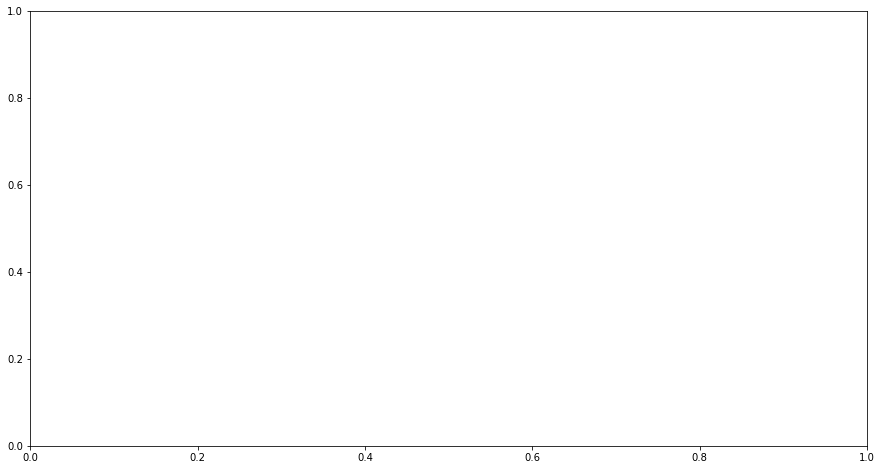

<Figure size 1080x576 with 0 Axes>

In [73]:
# new_normal_df1['grouplabel'] = 'private'
# new_tcpsyn_df1['grouplabel'] = 'private'

# new_Pnormal_df1['grouplabel'] = 'public'
# new_Ptcpsyn_df1['grouplabel'] = 'public'

# joined_tcpsyn = pd.concat([new_tcpsyn_df1, new_Ptcpsyn_df1]).reset_index(drop=True)
# joined_normal = pd.concat([new_normal_df1, new_Pnormal_df1]).reset_index(drop=True)

# # plt.figure(figsize=(15,7))
# # sns.countplot(x='grouplabel', 
# #               hue='label',
# #               data=joined_tcps)
# # plt.title("TCP count of Normal and tcpsyn attack (1min traffic)", fontdict = font1)
# # plt.show()

# # tcpsyn tcpsyn (first 50 packets)7
# plt.figure(figsize = (15,8))
# g = sns.pointplot(x=new_Ptcpsyn_df1.index[:50], y='Protocol',
#               hue='grouplabel', 
#               data=joined_tcpsyn[:50]
#               )
# plt.xticks(rotation=90)
# plt.title("tcpsyn attack Protocal Variation (first 50 packets - 1min traffic (Public))", fontdict = font1)
# # rename the legend
# current_handles, current_labels = plt.gca().get_legend_handles_labels()
# new_labels = [sorted(set(public_tcpsyn_df.Protocol))[int(i)] for i in current_labels]  # recode the protocol label
# plt.legend(current_handles, new_labels)  # call plt.legend() with the new values


fig, ax = plt.subplots(1, 2, figsize=(20,7))
# tcpsyn tcpsyn (first 50 packets)
plt.figure(figsize = (15,8))
g = sns.pointplot(x=new_tcpsyn_df1.index[:50], y='Protocol',
              hue='Protocol', 
              data=new_tcpsyn_df1[:50],
              ax = ax[0]
              )
ax[0].set_xticklabels(labels=list(range(1,51)),rotation=90)
ax[0].set_xlabel('frame no')
ax[0].set_title("tcpsyn tcpsyn Protocal Variation (first 50 packets - 1min traffic)", fontdict = font1)
# rename the legend
current_handles, current_labels = plt.gca().get_legend_handles_labels()
new_labels = [sorted(set(tcpsyn_df1.Protocol))[int(i)] for i in current_labels]  # recode the protocol label
ax[0].legend(current_handles, new_labels)  # call plt.legend() with the new values

# tcpsyn tcpsyn (first 50 packets)
plt.figure(figsize = (15,8))
g = sns.pointplot(x=new_Ptcpsyn_df1.index[:50], y='Protocol',
              hue='Protocol', 
              data=new_Ptcpsyn_df1[:50],
              ax=ax[1]
              )
ax[1].set_xticklabels(labels=list(range(1,51)),rotation=90)
ax[1].set_xlabel('frame no')
ax[1].set_title("tcpsyn attack Protocal Variation (first 50 packets - 1min traffic (Public))", fontdict = font1)
# rename the legend
current_handles, current_labels = plt.gca().get_legend_handles_labels()
new_labels = [sorted(set(public_tcpsyn_df.Protocol))[int(i)] for i in current_labels]  # recode the protocol label
ax[1].legend(current_handles, new_labels)  # call plt.legend() with the new values

### sequence number variation

##### Private

In [115]:
# MinMax Scaling
# normal_df1.loc[:,['Length']].apply(lambda x: (x-x.min())/(x.max() - x.min()), axis=0)
normal_df1['Sequence number'] = MinMaxScaler().fit_transform(normal_df1.loc[:,['Sequence number']])
tcpsyn_df1['Sequence number'] = MinMaxScaler().fit_transform(tcpsyn_df1.loc[:,['Sequence number']])

In [86]:
# tcpsyn tcpsyn (all packets)
# plt.figure(figsize = (15,8))
# sns.pointplot(x=tcpsyn_df1.index, y='Sequence number',
#               hue='Protocol', 
#               data=tcpsyn_df1
#               )
# plt.xticks(rotation=90)
# plt.title("DDoS tcpsyn Sequence Number Variation (all packets - 1min traffic)", fontdict = font1)

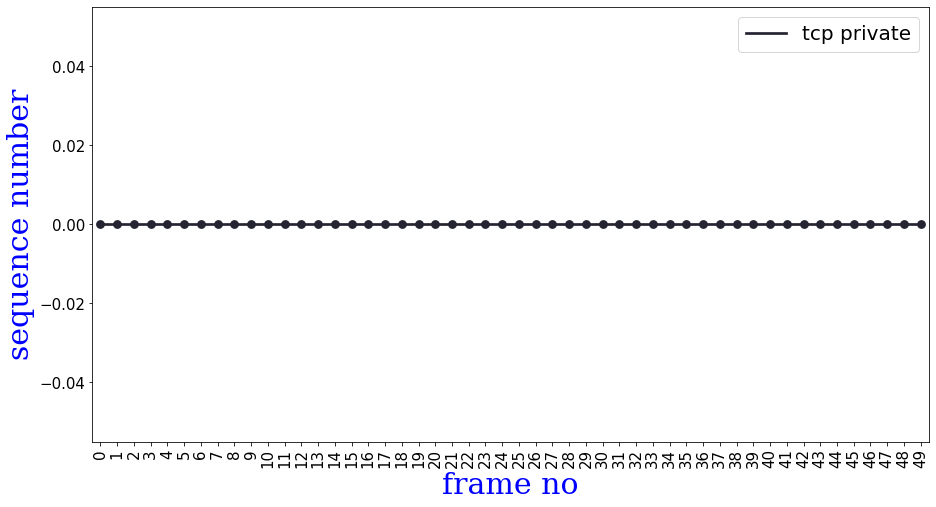

In [119]:
# tcpsyn data (first 50 packets)
plt.figure(figsize = (15,8))
sns.pointplot(x=tcpsyn_df1[:50].index, y='Sequence number',
             hue='Protocol', 
              data=tcpsyn_df1[:50],
              color='Blue'
              )
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('sequence number', fontdict = font1)
plt.xlabel('frame no', fontdict = font1)
plt.legend(['tcp private'], prop={"size":20})
# plt.title("DDoS tcpsyn Sequence Number Variation (first 50 packets - 1min traffic)", fontdict = font1)

# # tcpsyn data (last 50 packets)
# plt.figure(figsize = (15,8))
# sns.pointplot(x=tcpsyn_df1[-50:].index, y='Sequence number',
#               hue='Protocol', 
#               data=tcpsyn_df1[-50:]
#               )
# plt.xticks(rotation=90)
# plt.title("DDoS tcpsyn Sequence Number Variation (last 50 packets - 1min traffic)", fontdict = font1)

# # Normal data 
# plt.figure(figsize = (15,8))
# sns.pointplot(x=normal_df1.index, y='Sequence number',
#               hue='Protocol', 
#               data=normal_df1)
# plt.xticks(rotation=90)
# plt.title("Normal Sequence Number Variation (all packets - 1min traffic)", fontdict = font1)
# # plt.xlabel("Packet No.", fontdict = font2)

##### Public

C:\Users\OLUWAS~1.APE\AppData\Local\Temp/ipykernel_17048/3987887797.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  public_normal_df['Sequence number'] = MinMaxScaler().fit_transform(public_normal_df.loc[:,['Sequence Number']])


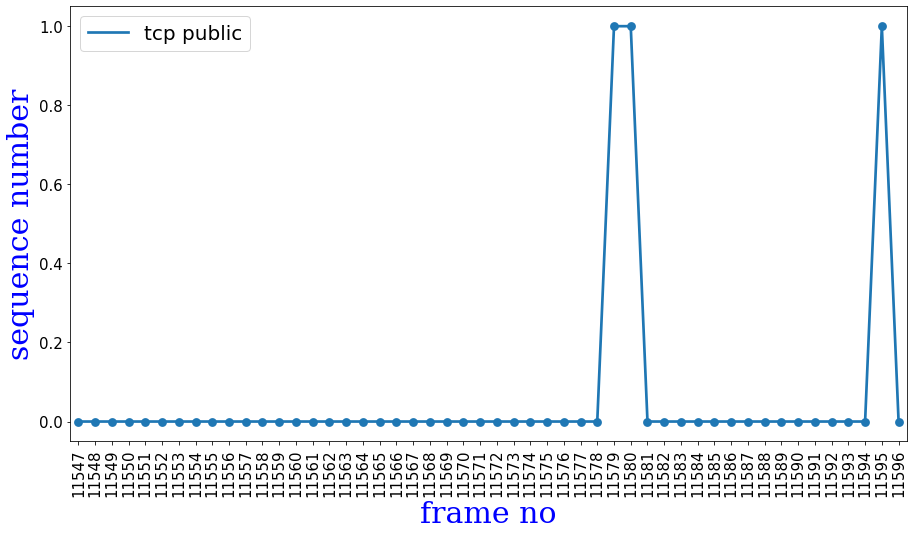

In [117]:
# MinMax Scaling
# normal_df1.loc[:,['Length']].apply(lambda x: (x-x.min())/(x.max() - x.min()), axis=0)
public_normal_df['Sequence number'] = MinMaxScaler().fit_transform(public_normal_df.loc[:,['Sequence Number']])
public_tcpsyn_df['Sequence number'] = MinMaxScaler().fit_transform(public_tcpsyn_df.loc[:,['Sequence Number']])


# tcpsyn data (first 50 packets)
plt.figure(figsize = (15,8))
sns.pointplot(x=public_tcpsyn_df[:50].index, y='Sequence number',
             hue='Protocol', 
              data=public_tcpsyn_df[:50]
              )
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('sequence number', fontdict = font1)
plt.xlabel('frame no', fontdict = font1)
plt.legend(['tcp public'], prop={"size":20})
# plt.title("tcpsyn  Sequence Number Variation (first 50 packets - 1min traffic (Public))", fontdict = font1)

# # tcpsyn data (last 50 packets)
# plt.figure(figsize = (15,8))
# sns.pointplot(x=public_tcpsyn_df[-50:].index, y='Sequence number',
#               hue='Protocol', 
#               data=public_tcpsyn_df[-50:]
#               )
# plt.xticks(rotation=90)
# plt.title("tcpsyn attack Sequence Number Variation (last 50 packets - 1min traffic (Public))", fontdict = font1)

# # Normal data 
# plt.figure(figsize = (15,8))
# sns.pointplot(x=public_normal_df.index, y='Sequence number',
#               hue='Protocol', 
#               data=public_normal_df)
# plt.xticks(rotation=90)
# plt.title("Normal Sequence Number Variation (all packets - 1min traffic (Public))", fontdict = font1)
# plt.xlabel("Packet No.", fontdict = font2)

## Proportion of tcp flags

In [3]:
def extract_tcp_flag(n):
  pattern = r"\d\[\w*\W*\w*]|\W\[\w*\W*\w*]"
  pattern2 = r"[A-Z]{3}"
  a = ''.join(re.split("\s", n))
  b = re.findall(pattern, a)
  return ', '.join(re.findall(pattern2, b[0])) if b else np.nan


data['TCP flag'] = list(map(extract_tcp_flag, data.Info))
set(data['TCP flag'])

##### Extract TCP Flag

In [8]:

data = pd.read_csv('DDoS UDPPRIVATE.csv')
data['TCP flag'] = list(map(extract_tcp_flag, data.Info))
print(set(data['TCP flag']))
data.to_csv('DDoS UDPPRIVATE flag.csv')
data.head()

{nan, 'PSH, ACK', 'ACK', 'RST', 'FIN, ACK', 'SYN, ACK'}


,No.,Time,Source,Destination,Protocol,Length,Sequence Number,Info,TCP flag
0,23,15.170484,52.31.1.61,192.168.0.104,TLSv1.2,97,1.0,Application Data,NaN
1,26,18.844370,192.168.0.1,192.168.0.104,DNS,162,NaN,Standard query response 0xb58c A c3t5k8kx91jab...,NaN
2,28,18.872413,34.255.239.242,192.168.0.104,TCP,74,0.0,"443 > 45708 [SYN, ACK] Seq=0 Ack=1 Win=26847...","SYN, ACK"
3,31,18.952147,34.255.239.242,192.168.0.104,TCP,66,1.0,443 > 45708 [ACK] Seq=1 Ack=455 Win=28160 Le...,ACK
4,32,18.955173,34.255.239.242,192.168.0.104,TCP,1506,1.0,443 > 45708 [ACK] Seq=1 Ack=455 Win=28160 Le...,ACK


### all data flags

In [85]:
# # read all data
# all_data = pd.concat([
#     normal_df, 
#     public_normal_df, private_ICMP, \
# # public_ICMP, \
# tcpsyn_df, public_tcpsyn_df, private_UDP, public_UDP
# ]).reset_index(drop=True)

all_data = normal_df

print(set(all_data['name']))
all_data['TCP flag'] = list(map(extract_tcp_flag, all_data.Info))
print(set(all_data['TCP flag']))
all_data.to_csv('normal_df flag.csv')
# all_data.head()

{'benignprivate'}
{nan, 'TCP, ACK', 'FIN, ACK', 'PSH, ACK', 'TCP', 'RST', 'RST, ACK', 'SYN', 'ACK', 'SYN, ACK'}


##### Private

In [16]:
all_df = pd.concat([normal_df1, tcpsyn_df1]).reset_index(drop=True)
all_df['TCP flag'] = list(map(extract_tcp_flag, all_df.Info))
print(set(all_df['TCP flag']))
all_df.to_csv('all_journal_data.csv')
all_df.head()

{nan, 'FIN, ACK', 'RST', 'RST, ACK', 'SYN', 'ACK', 'SYN, ACK'}


,Time,Frame Number,Source,Destination,Protocol,Length,Sequence number,Info,name,label,TCP flag
0,89.028804,38,rcr-663.local,192.168.0.1,DNS,102,NaN,Standard query 0xda5f A kinesis.eu-west-1.amaz...,benignprivate,normal,NaN
1,89.038900,39,192.168.0.1,rcr-663.local,DNS,118,NaN,Standard query response 0xda5f A kinesis.eu-we...,benignprivate,normal,NaN
2,89.048131,40,rcr-663.local,kinesis.eu-west-1.amazonaws.com,TCP,74,0.0,55182 > https(443) [SYN] Seq=0 Win=65340 Len...,benignprivate,normal,SYN
3,89.068710,41,kinesis.eu-west-1.amazonaws.com,rcr-663.local,TCP,74,0.0,"https(443) > 55182 [SYN, ACK] Seq=0 Ack=1 Wi...",benignprivate,normal,"SYN, ACK"
4,89.069331,42,rcr-663.local,kinesis.eu-west-1.amazonaws.com,TCP,66,1.0,55182 > https(443) [ACK] Seq=1 Ack=1 Win=653...,benignprivate,normal,ACK


###### pie chart option

label   TCP flag
normal  ACK           38
        FIN, ACK       1
        SYN            1
        SYN, ACK       1
tcpsyn  SYN         7951
        ACK           19
        RST, ACK       4
        FIN, ACK       1
        RST            1
Name: TCP flag, dtype: int64

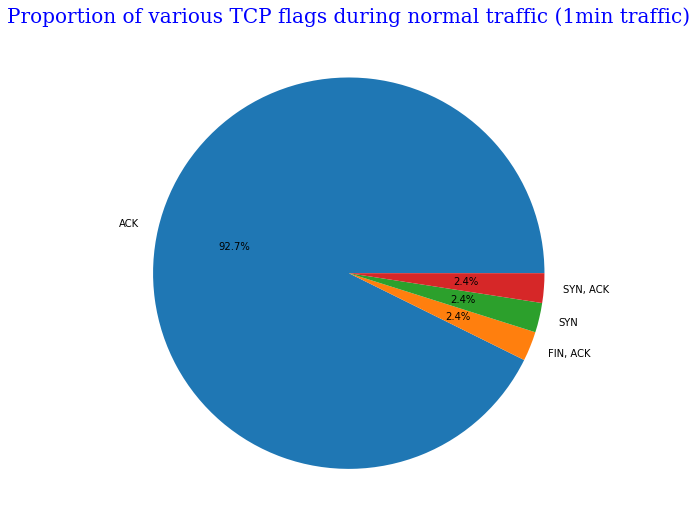

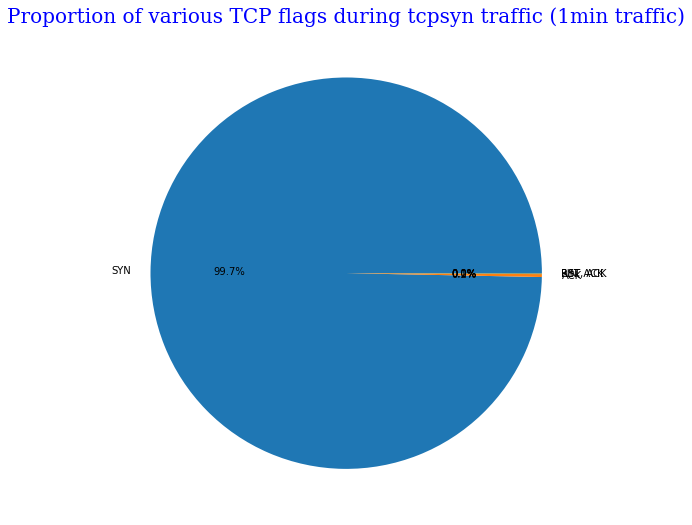

In [ ]:
all_df_groupby = all_df.groupby('label')['TCP flag'].value_counts(normalize=True)

# normal flag 
plt.figure(figsize=(15,9))
plt.pie(all_df_groupby['normal'], 
        # explode=explode, 
        labels=all_df_groupby['normal'].index,
        autopct='%1.1f%%',
        # startangle=90, # to rotate the chart
        )
plt.title("Proportion of various TCP flags during normal traffic (1min traffic)", fontdict = font1)

# tcpsyn flag 
plt.figure(figsize=(15,9))
plt.pie(all_df_groupby['tcpsyn'], 
        # explode=explode, 
        labels=all_df_groupby['tcpsyn'].index,
        autopct='%1.1f%%',
        # startangle=90, # to rotate the chart
        )
plt.title("Proportion of various TCP flags during tcpsyn traffic (1min traffic)", fontdict = font1)

all_df.groupby('label')['TCP flag'].value_counts()

###### Bar chat option

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


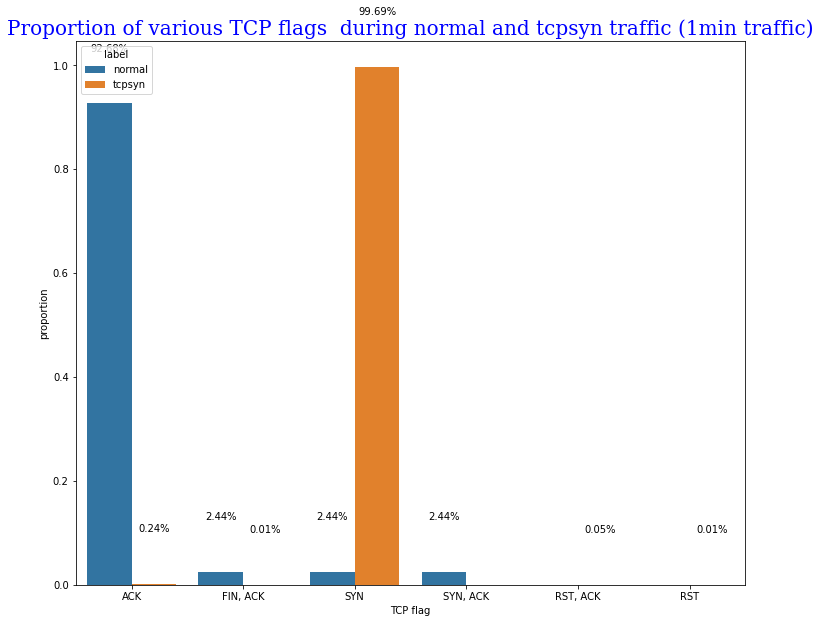

In [ ]:
# tcp flag plot
x, y, hue = "TCP flag", "proportion", "label"
plt.figure(figsize=(12,10))
ax = (all_df[x]
 .groupby(all_df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))
plt.title("Proportion of various TCP flags  during normal and tcpsyn traffic (1min traffic)", fontdict = font1)

 # to add the % on the chart
for p in ax.patches:
   height = p.get_height()
   ax.text(x=p.get_x() + p.get_width() / 2, y=height+.10,
      s="{:.2f}%".format(height*100),
      ha='center')
   
# # to add the % on the chart (does work)
# patches = ax.patches
# for i in range(len(patches)):
#    xi = patches[i].get_x() + patches[i].get_width()/2
#    yi = patches[i].get_height()+.05
#    ax.annotate('{:.1f}%'.format(percentage[i]), (xi, yi), ha='center')    # find way of getting out the 'percentage'

##### Public

In [57]:
Pall_df = pd.concat([public_normal_df, public_tcpsyn_df]).reset_index(drop=True)
Pall_df['TCP flag'] = list(map(extract_tcp_flag, Pall_df.Info))
print(set(Pall_df['TCP flag']))
Pall_df.to_csv('all_journal_data.csv')
Pall_df.head()

{nan, 'RST', 'PSH, ACK', 'SYN', 'SYN, ACK', 'ACK'}


,No.,Time,Source,Destination,Protocol,Length,Sequence Number,Info,name,label,Sequence number,TCP flag
0,332,546.263114,192.168.1.1,192.168.1.158,DHCP,342,NaN,DHCP Offer - Transaction ID 0xabcd0001,benignpublic_somfylock,normal,NaN,NaN
1,333,546.263121,192.168.1.1,192.168.1.158,DHCP,342,NaN,DHCP Offer - Transaction ID 0xabcd0001,benignpublic_somfylock,normal,NaN,NaN
2,351,547.061661,192.168.1.1,192.168.1.158,DHCP,342,NaN,DHCP Offer - Transaction ID 0xabcd0001,benignpublic_somfylock,normal,NaN,NaN
3,352,547.061667,192.168.1.1,192.168.1.158,DHCP,342,NaN,DHCP Offer - Transaction ID 0xabcd0001,benignpublic_somfylock,normal,NaN,NaN
4,359,547.092639,192.168.1.1,192.168.1.158,DHCP,342,NaN,DHCP ACK - Transaction ID 0xabcd0001,benignpublic_somfylock,normal,NaN,NaN


label   TCP flag
normal  ACK             54
        PSH, ACK        37
        SYN              2
        SYN, ACK         2
tcpsyn  SYN         950141
        RST         201224
        ACK              7
Name: TCP flag, dtype: int64

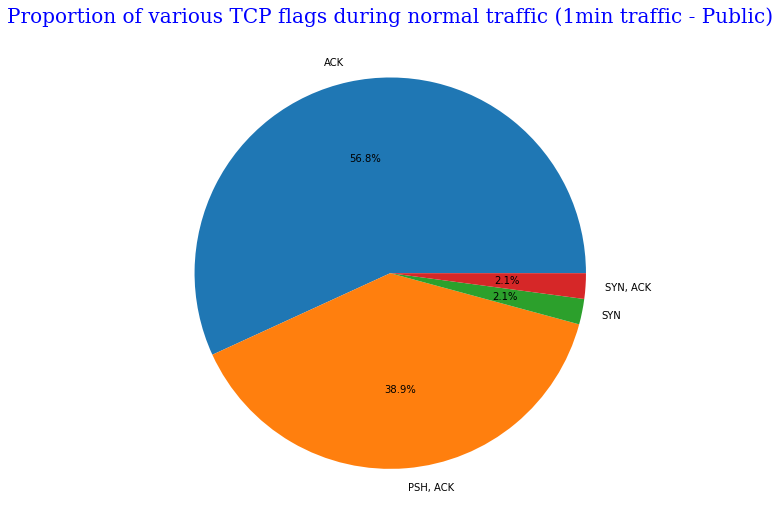

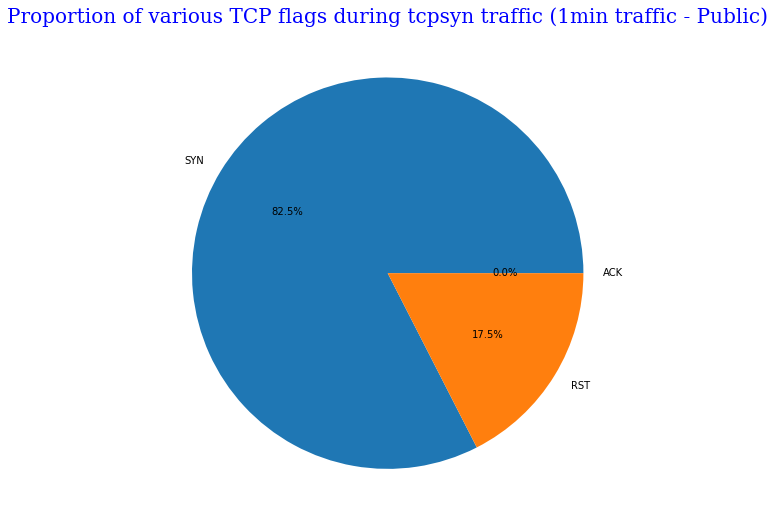

In [58]:
public_normal_first50 = public_normal_df[:50]#.reset_index(drop=True)
public_normal_last50 = public_normal_df[-50:]#.reset_index(drop=True)

public_tcpsyn_first50 = public_tcpsyn_df[:50]#.reset_index(drop=True)
public_tcpsyn_last50 = public_tcpsyn_df[-50:]#.reset_index(drop=True)

Pall_df_groupby = Pall_df.groupby('label')['TCP flag'].value_counts(normalize=True)

# normal flag 
plt.figure(figsize=(15,9))
plt.pie(Pall_df_groupby['normal'], 
        # explode=explode, 
        labels=Pall_df_groupby['normal'].index,
        autopct='%1.1f%%',
        # startangle=90, # to rotate the chart
        )
plt.title("Proportion of various TCP flags during normal traffic (1min traffic - Public)", fontdict = font1)

# tcpsyn flag 
plt.figure(figsize=(15,9))
plt.pie(Pall_df_groupby['tcpsyn'], 
        # explode=explode, 
        labels=Pall_df_groupby['tcpsyn'].index,
        autopct='%1.1f%%',
        # startangle=90, # to rotate the chart
        )
plt.title("Proportion of various TCP flags during tcpsyn traffic (1min traffic - Public)", fontdict = font1)

Pall_df.groupby('label')['TCP flag'].value_counts()

## incoming and out going packet flow

Text(0.5, 1.0, 'DDoS Attck Traffic flow (1min traffic)')

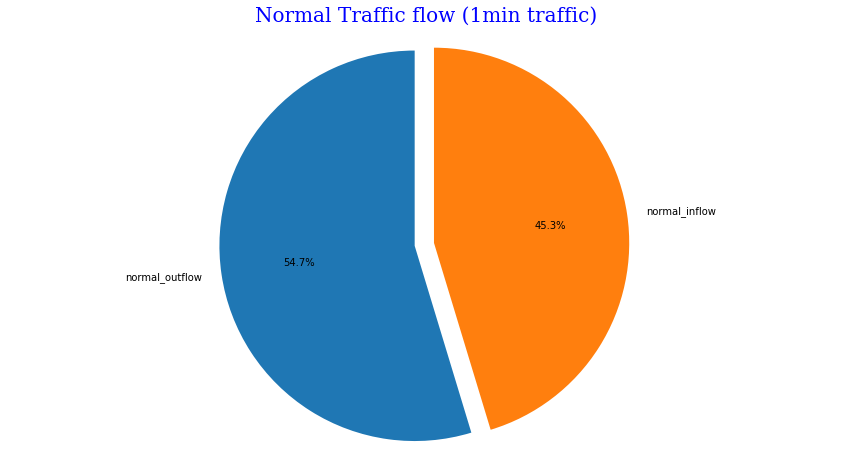

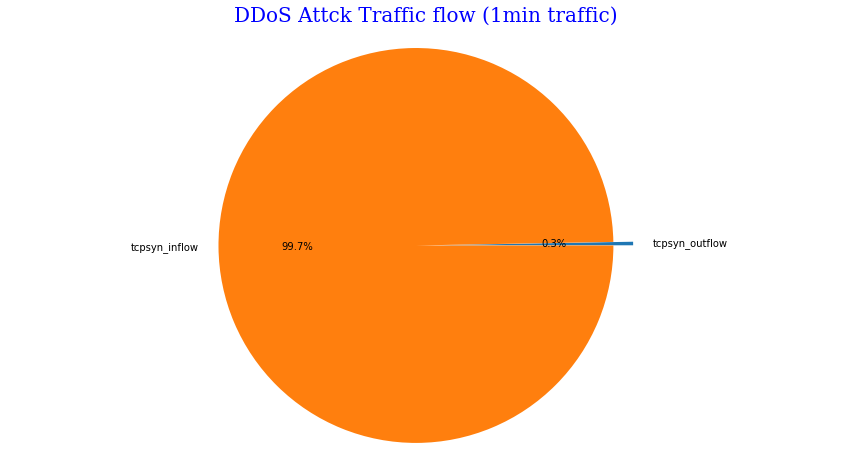

In [ ]:
# normal inflow 
ip = 'rcr-663.local' 
x = ['normal_outflow', 'normal_inflow']
y = [len(normal_df1[normal_df1.loc[:,'Source'] == ip]), len(normal_df1[normal_df1.loc[:,'Source'] != ip])]

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
# fig1, ax1 = plt.subplots()
plt.figure(figsize = (15,8))
explode = (0, 0.1)  # only "explode" the 2nd slice
plt.pie(y, 
        explode=explode, 
        labels=x, 
        autopct='%1.1f%%',
        # shadow=True,
        startangle=90 # to rotate the chart
        )
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Normal Traffic flow (1min traffic)", fontdict = font1)

# bar plot option
# plt.figure(figsize = (15,8))
# sns.barplot(x, y)
# plt.title("Normal Traffic flow (1min traffic)", fontdict = font1)

# tcpsyn inflow
ip2 = '192.168.0.100'
plt.figure(figsize = (15,8))
x = ['tcpsyn_outflow', 'tcpsyn_inflow']
y = [len(tcpsyn_df1[tcpsyn_df1.loc[:,'Source'] == ip2]), len(tcpsyn_df1[tcpsyn_df1.loc[:,'Source'] != ip2])]

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
# fig1, ax1 = plt.subplots()
explode = (0, 0.1)  # only "explode" the 2nd slice
plt.pie(y, 
        explode=explode, 
        labels=x, 
        autopct='%1.1f%%',
        # shadow=True,
        # startangle=90 # to rotate the chart
        )
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("DDoS Attck Traffic flow (1min traffic)", fontdict = font1)

#bar option
# plt.figure(figsize = (15,8))# Pie chart, where the slices will be ordered and plotted counter-clockwise:
# sns.barplot(x, y)
# plt.title("DDoS Attck Traffic flow (1min traffic)", fontdict = font1)

In [ ]:
# both flow data in dataframe
pd.DataFrame({'flow_type': ['normal_outflow', 'normal_inflow', 'tcpsyn_outflow', 'tcpsyn_inflow'],
             'packet_counts':[len(normal_df1[normal_df1.loc[:,'Source'] == ip]),
                len(normal_df1[normal_df1.loc[:,'Source'] != ip]),
                len(tcpsyn_df1[tcpsyn_df1.loc[:,'Source'] == ip2]),
                len(tcpsyn_df1[tcpsyn_df1.loc[:,'Source'] != ip2])
                ]}
             )

,flow_type,packet_counts
0,normal_outflow,35
1,normal_inflow,29
2,tcpsyn_outflow,23
3,tcpsyn_inflow,7964


# UDP attack

In [124]:
# # read data
# private_UDP = pd.read_csv('/content/UDPprivate.csv',
#                         #  engine='python'
#                           # index_col='No.'
#                           )
# public_UDP = pd.read_csv('/content/UDPpublicfiltered.csv',
#                         #  engine='python'
#                          )

private_UDP = datalist[6][895:37161]
public_UDP = datalist[7]
public_UDP

,No.,Time,Source,Destination,Protocol,Length,Sequence Number,Info,name
0,2,0.000007,192.168.100.55,192.168.100.3,TCP,830,1.0,8080 > 80 [<None>] Seq=1 Win=1024 Len=776,UDPpublicfiltered
1,4,0.000011,192.168.100.6,192.168.100.3,TCP,296,1.0,80 > 80 [<None>] Seq=1 Win=1024 Len=242,UDPpublicfiltered
2,9,0.012405,192.168.100.55,192.168.100.3,TCP,1313,1.0,[TCP Retransmission] 8080 > 80 [<None>] Seq=...,UDPpublicfiltered
3,14,0.016403,192.168.100.5,192.168.100.3,TCP,475,1.0,0 > 0 [<None>] Seq=1 Win=1024 Len=421,UDPpublicfiltered
4,15,0.016405,192.168.100.7,192.168.100.3,UDP,60,NaN,365 > 565 Len=18,UDPpublicfiltered
...,...,...,...,...,...,...,...,...,...
2309724,2339190,73.612381,192.168.100.150,192.168.100.3,UDP,60,NaN,10988 > 80 Len=0,UDPpublicfiltered
2309725,2339191,73.612381,192.168.100.150,192.168.100.3,UDP,60,NaN,10989 > 80 Len=0,UDPpublicfiltered
2309726,2339192,73.612382,192.168.100.150,192.168.100.3,UDP,60,NaN,10990 > 80 Len=0,UDPpublicfiltered
2309727,2339193,73.612382,192.168.100.150,192.168.100.3,UDP,60,NaN,10991 > 80 Len=0,UDPpublicfiltered


### protocol variation

In [125]:
# preprocess
UDP_protocols = {q:p for p,q in enumerate(sorted(set(private_UDP.Protocol)))}
pUDP_protocols = {q:p for p,q in enumerate(sorted(set(public_UDP.Protocol)))}
print('private data encoding:', UDP_protocols)
print('public data encoding:', pUDP_protocols)
new_private_UDP = private_UDP.copy() # create a new data because of the label encoding
new_public_UDP = public_UDP.copy() # create a new data because of the label encoding
new_private_UDP.Protocol = LabelEncoder().fit_transform(new_private_UDP.Protocol) 
new_public_UDP.Protocol = LabelEncoder().fit_transform(new_public_UDP.Protocol)

new_public_UDP_first50 = new_public_UDP[(new_public_UDP['No.'] >= 34700) & (new_public_UDP['No.'] < 34751)]
new_public_UDP_last50 = new_public_UDP[(new_public_UDP['No.'] >= 2339144) & (new_public_UDP['No.'] < 2339195)]

private data encoding: {'ICMP': 0, 'MDNS': 1, 'TCP': 2, 'TLSv1.2': 3, 'UDP': 4}
public data encoding: {'ICMP': 0, 'TCP': 1, 'UDP': 2}


In [126]:
new_public_UDP_first50.head()

,No.,Time,Source,Destination,Protocol,Length,Sequence Number,Info,name
11555,34700,57.785946,192.168.100.147,192.168.100.3,2,60,NaN,2039 > 80 Len=0,UDPpublicfiltered
11556,34701,57.785947,192.168.100.147,192.168.100.3,2,60,NaN,2040 > 80 Len=0,UDPpublicfiltered
11557,34702,57.785948,192.168.100.147,192.168.100.3,2,60,NaN,2041 > 80 Len=0,UDPpublicfiltered
11558,34703,57.785949,192.168.100.147,192.168.100.3,2,60,NaN,2042 > 80 Len=0,UDPpublicfiltered
11559,34704,57.785951,192.168.100.147,192.168.100.3,2,60,NaN,2043 > 80 Len=0,UDPpublicfiltered


In [15]:
# # Private (all packets) (causing out of memory error)
# plt.figure(figsize = (15,8))
# g = sns.pointplot(x=new_private_UDP.index, y='Protocol',
#               hue='Protocol',          
#               data=new_private_UDP,
#               facet_kws={'legend_out': True} # to make the legend available through the g._legend 
#               )
# plt.xticks(rotation=90)
# plt.title("UDP attack protocal Variation (all packets - 1min traffic)", fontdict = font1)
# # rename the legend
# current_handles, current_labels = plt.gca().get_legend_handles_labels()
# new_labels = [sorted(set(private_UDP.Protocol))[int(i)] for i in current_labels]  # recode the protocol label
# plt.legend(current_handles, new_labels)  # call plt.legend() with the new values

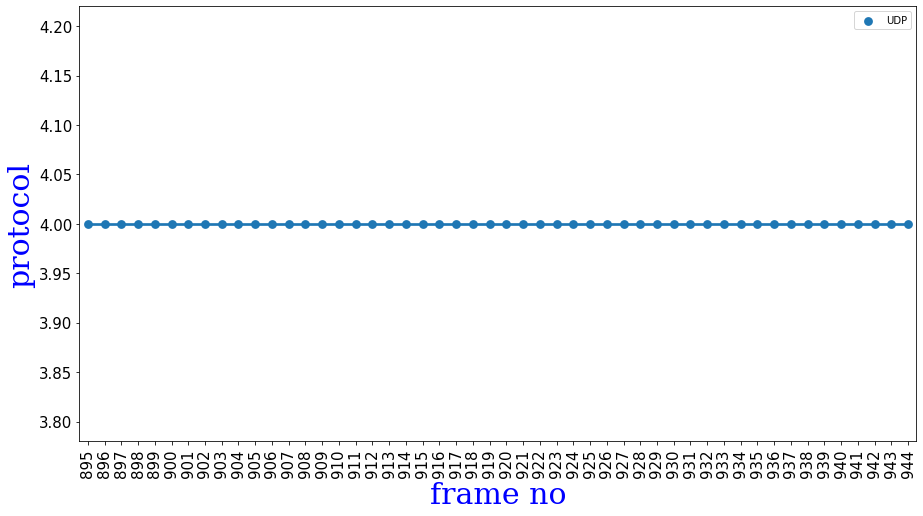

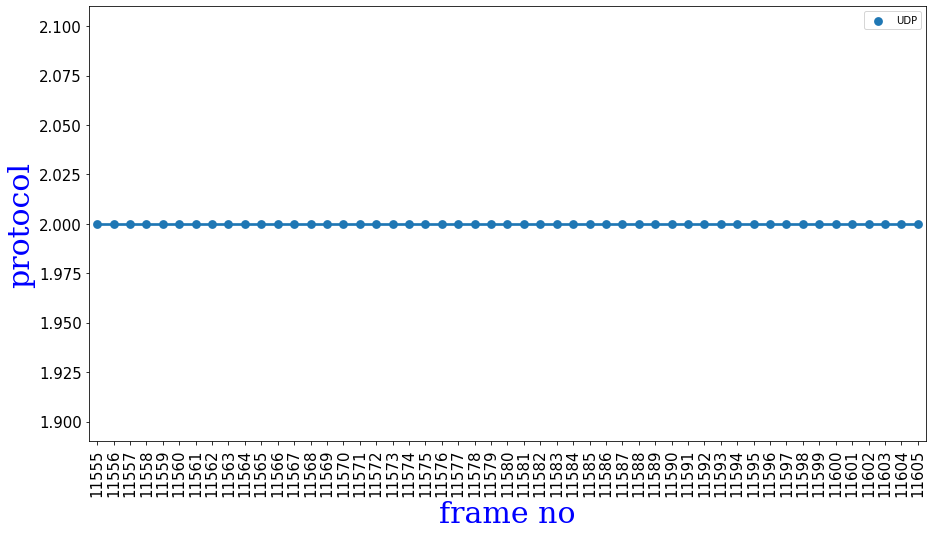

In [127]:
# Private (first 50 packets)
plt.figure(figsize = (15,8))
g = sns.pointplot(x=new_private_UDP.index[:50], y='Protocol',
              hue='Protocol',          
              data=new_private_UDP[:50],
              facet_kws={'legend_out': True} # to make the legend available through the g._legend 
              )
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('protocol', fontdict = font1)
plt.xlabel('frame no', fontdict = font1)
# plt.legend(['tcp private'], prop={"size":20})
# plt.title("UDP attack protocal Variation (first 50 packets - 1min traffic)", fontdict = font1)
# rename the legend
current_handles, current_labels = plt.gca().get_legend_handles_labels()
new_labels = [sorted(set(private_UDP.Protocol))[int(i)] for i in current_labels]  # recode the protocol label
plt.legend(current_handles, new_labels)  # call plt.legend() with the new values

# # Private (last 50 packets)
# plt.figure(figsize = (15,8))
# g = sns.pointplot(x=new_private_UDP.index[-50:], y='Protocol',
#               hue='Protocol',          
#               data=new_private_UDP[-50:],
#               facet_kws={'legend_out': True} # to make the legend available through the g._legend 
#               )
# plt.xticks(rotation=90)
# plt.title("UDP attack protocal Variation (Last 50 packets - 1min traffic)", fontdict = font1)
# # rename the legend
# current_handles, current_labels = plt.gca().get_legend_handles_labels()
# new_labels = [sorted(set(private_UDP.Protocol))[int(i)] for i in current_labels]  # recode the protocol label
# plt.legend(current_handles, new_labels)  # call plt.legend() with the new values

# Public 
# first 50 packets
plt.figure(figsize = (15,8))
g = sns.pointplot(x=new_public_UDP_first50.index, y='Protocol',
              hue='Protocol', 
              data=new_public_UDP_first50
              )
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('protocol', fontdict = font1)
plt.xlabel('frame no', fontdict = font1)
# plt.legend(['tcp private'], prop={"size":20})
# plt.title("UDP attack protocal Variation (first 50 packets - 1min traffic [Public])", fontdict = font1)
# rename the legend
current_handles, current_labels = plt.gca().get_legend_handles_labels()
new_labels = [sorted(set(public_UDP.Protocol))[int(i)] for i in current_labels]  # recode the protocol label
plt.legend(current_handles, new_labels)  # call plt.legend() with the new values

# last 50 packets
# plt.figure(figsize = (15,8))
# g = sns.pointplot(x=new_public_UDP_last50.index, y='Protocol',
#               hue='Protocol', 
#               data=new_public_UDP_last50
#               )
# plt.xticks(rotation=90)
# plt.title("UDP attack protocal Variation (last 50 packets - 1min traffic [Public])", fontdict = font1)
# # rename the legend
# current_handles, current_labels = plt.gca().get_legend_handles_labels()
# new_labels = [sorted(set(public_UDP.Protocol))[int(i)] for i in current_labels]  # recode the protocol label
# plt.legend(current_handles, new_labels)  # call plt.legend() with the new values

# plt.xlabel("packet no.")

### Packet Lenght Variation

In [128]:
private_UDP_df = datalist[6][895:37161]

# MinMax Scaling
private_UDP_df['Length'] = MinMaxScaler().fit_transform(private_UDP_df.loc[:,['Length']])
public_UDP['Length'] = MinMaxScaler().fit_transform(public_UDP.loc[:,['Length']])


public_UDP_first50 = public_UDP[(public_UDP['No.'] >= 34700) & (public_UDP['No.'] < 34751)]
public_UDP_last50 = public_UDP[(public_UDP['No.'] >= 2339144) & (public_UDP['No.'] < 2339195)]

# # public_UDP_first50 = public_UDP[34700:34751]
# # public_UDP_last50 = public_UDP[2339144:2339195]
# public_UDP_first50 = public_UDP[:50]
# public_UDP_last50 = public_UDP[-50:]

C:\Users\OLUWAS~1.APE\AppData\Local\Temp/ipykernel_17048/3368271032.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  private_UDP_df['Length'] = MinMaxScaler().fit_transform(private_UDP_df.loc[:,['Length']])


KeyboardInterrupt: 

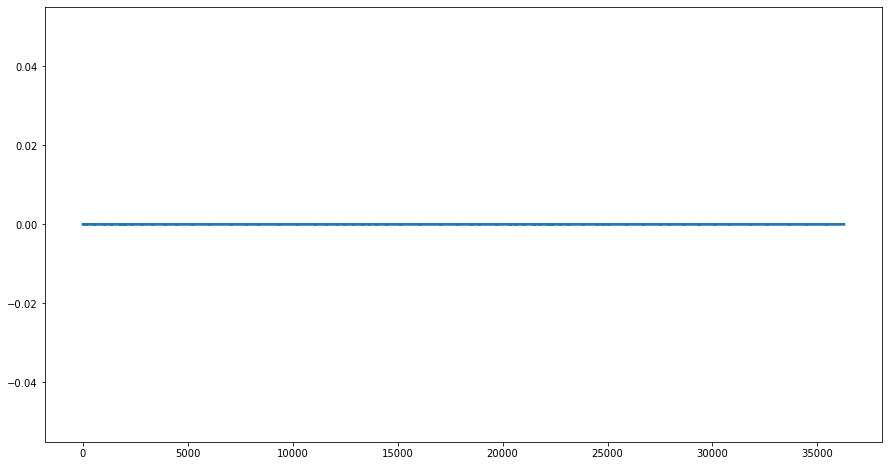

In [8]:
# private data 
plt.figure(figsize = (15,8))
sns.pointplot(x=private_UDP_df.index, y='Length',
              hue='Protocol', 
              data=private_UDP_df)
plt.xticks(rotation=90)
plt.xticks(rotation=90)
plt.title("UDP attack packet Length Variation (all packets - 1min traffic)", fontdict = font1)

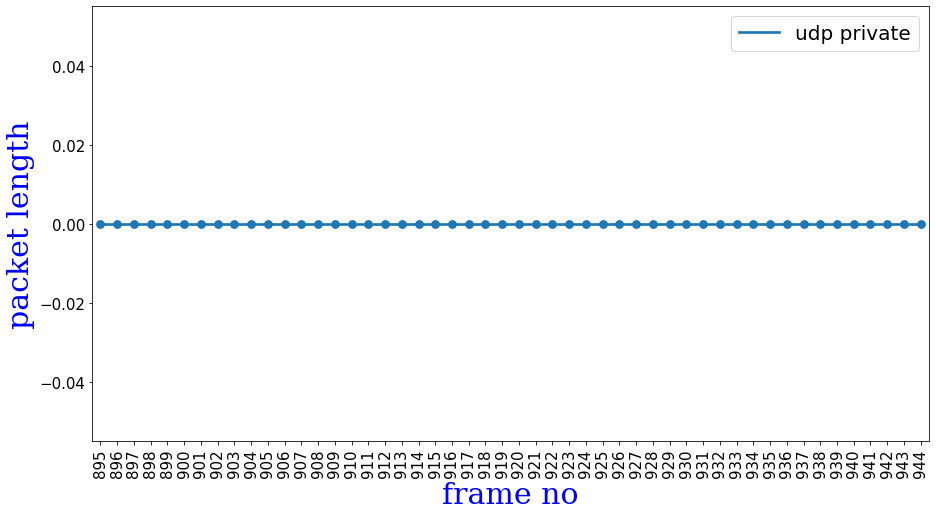

In [132]:
# private data (first 50 packets)
plt.figure(figsize = (15,8))
sns.pointplot(x=private_UDP_df.index[:50], y='Length',
              hue='Protocol', 
              data=private_UDP_df[:50])
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('packet length', fontdict = font1)
plt.xlabel('frame no', fontdict = font1)
plt.legend(['udp private'], prop={"size":20})
# plt.title("UDP attack packet Length Variation (first 100 packets - 1min traffic)", fontdict = font1)

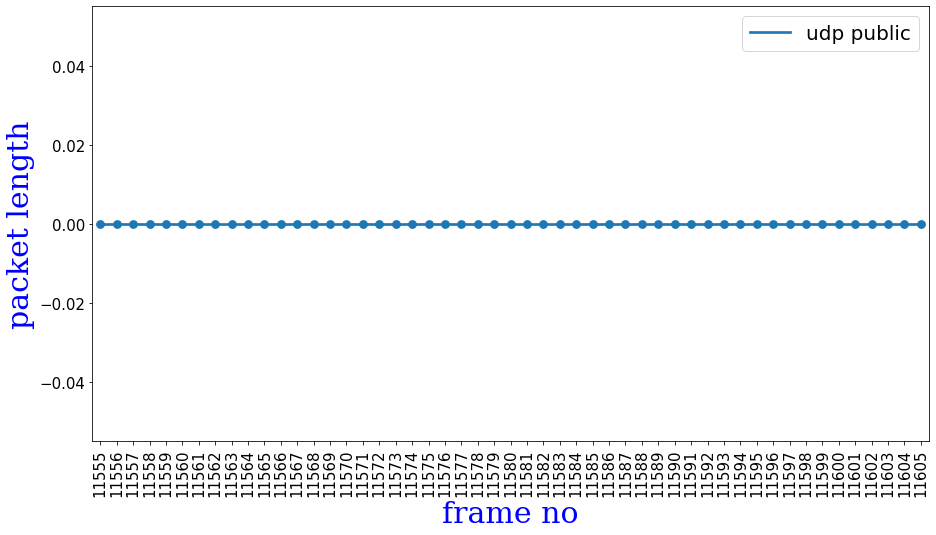

In [133]:
# Public ATTACK data 
# first 50 packets
plt.figure(figsize = (15,8))
sns.pointplot(x=public_UDP_first50.index, y='Length',
              hue='Protocol', 
              data=public_UDP_first50
              )
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('packet length', fontdict = font1)
plt.xlabel('frame no', fontdict = font1)
plt.legend(['udp public'], prop={"size":20})
# plt.title("UDP attack packet length Variation (first 50 packets - 1min traffic - [Public])", fontdict = font1)

# # last 50 packets
# plt.figure(figsize = (15,8))
# sns.pointplot(x=public_UDP_last50.index, y='Length',
#               hue='Protocol', 
#               data=public_UDP_last50
#               )
# plt.xticks(rotation=90)
# plt.xticks(rotation=90)
# plt.title("UDP attack packet length Variation (last 50 packets - 1min traffic - [Public])", fontdict = font1)

# ICMP attack

In [9]:
[n.name[0] for n in datalist]   # view the arrangement of the files

['benignprivate',
 'benignpublic_somfylock',
 'ICMPprivate',
 'ICMPpublic',
 'TCPSYNprivate',
 'TCPSYNpublicfiltered',
 'UDPprivate',
 'UDPpublicfiltered']

In [58]:
# read data
# private_ICMP = pd.read_csv('/content/ICMPprivate.csv')
public_ICMP = pd.read_csv('..data/large_data/public/ICMPpublic.csv')

private_ICMP = datalist[2][(datalist[2]['No.'] >= 155) & (datalist[2]['No.'] < 11412)]
public_ICMP = datalist[3]
public_ICMP.head()

FileNotFoundError: [Errno 2] No such file or directory: '/J_data/public/ICMPpublic.csv'

### Protocol variation

In [135]:
# preprocess
ICMP_protocols = {q:p for p,q in enumerate(sorted(set(private_ICMP.Protocol)))}
pICMP_protocols = {q:p for p,q in enumerate(sorted(set(public_ICMP.protocol)))}
print('private data encoding:', ICMP_protocols)
print('public data encoding:', pICMP_protocols)
new_private_ICMP = private_ICMP.copy() # create a new data because of the label encoding
new_public_ICMP = public_ICMP.copy() # create a new data because of the label encoding
new_private_ICMP.Protocol = LabelEncoder().fit_transform(new_private_ICMP.Protocol) 
new_public_ICMP.protocol = LabelEncoder().fit_transform(new_public_ICMP.protocol)

private data encoding: {'ICMP': 0, 'MDNS': 1, 'TCP': 2, 'TLSv1.2': 3}
public data encoding: {'DNS': 0, 'HTTP': 1, 'ICMP': 2, 'TCP': 3, 'UDP': 4}


In [137]:
# # Private (all packets)
# plt.figure(figsize = (15,8))
# g = sns.pointplot(x=new_private_ICMP.index, y='Protocol',
#               hue='Protocol',          
#               data=new_private_ICMP,
#               facet_kws={'legend_out': True} # to make the legend available through the g._legend 
#               )
# plt.xticks(rotation=90, fontsize=15)
# plt.yticks(fontsize=15)
# plt.ylabel('protocol', fontdict = font1)
# plt.xlabel('frame no', fontdict = font1)
# # plt.title("ICMP attack protocal Variation (all packets - 1min traffic)", fontdict = font1)
# # rename the legend
# current_handles, current_labels = plt.gca().get_legend_handles_labels()
# new_labels = [sorted(set(private_ICMP.Protocol))[int(i)] for i in current_labels]  # recode the protocol label
# plt.legend(current_handles, new_labels)  # call plt.legend() with the new values

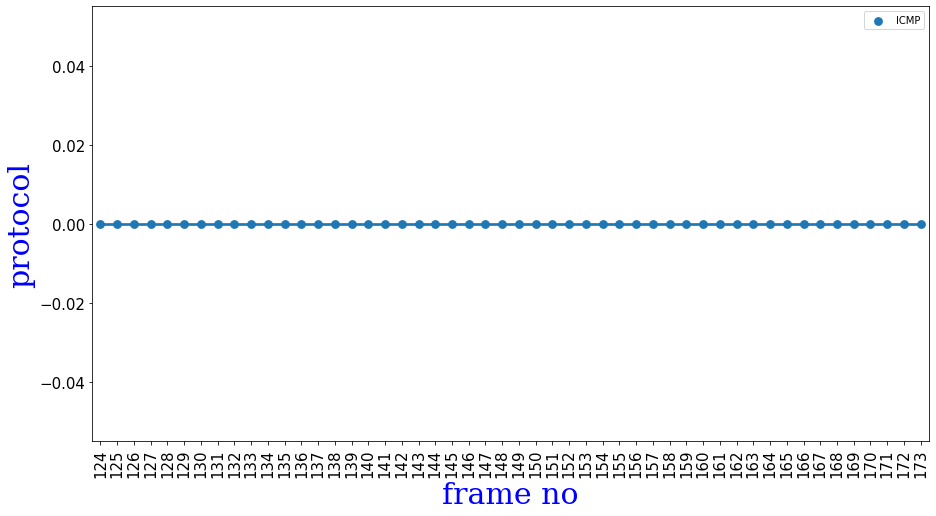

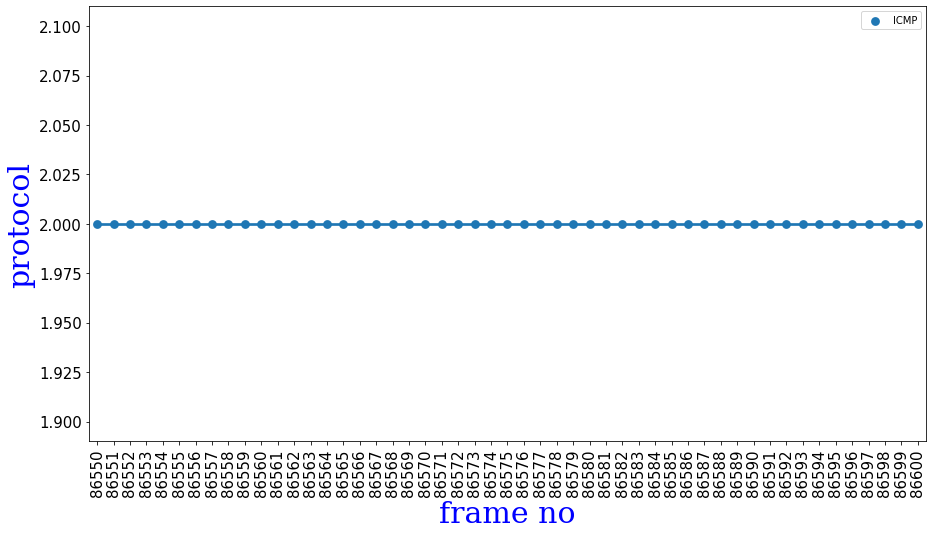

In [138]:
# private (first 50 packets)
plt.figure(figsize = (15,8))
g = sns.pointplot(x=new_private_ICMP[:50].index, y='Protocol',
              hue='Protocol',          
              data=new_private_ICMP[:50],
              facet_kws={'legend_out': True} # to make the legend available through the g._legend 
              )
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('protocol', fontdict = font1)
plt.xlabel('frame no', fontdict = font1)
# plt.title("ICMP attack protocal Variation (first 100 packets - 1min traffic)", fontdict = font1)
# rename the legend
current_handles, current_labels = plt.gca().get_legend_handles_labels()
new_labels = [sorted(set(private_ICMP.Protocol))[int(i)] for i in current_labels]  # recode the protocol label
plt.legend(current_handles, new_labels)  # call plt.legend() with the new values

# Public
# first 50 packets
plt.figure(figsize = (15,8))
g = sns.pointplot(x=new_public_ICMP.index[86550:86601], y='protocol',
              hue='protocol', 
              data=new_public_ICMP[86550:86601]
              )
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('protocol', fontdict = font1)
plt.xlabel('frame no', fontdict = font1)
# plt.legend(['udp private'], prop={"size":20})
# plt.title("ICMP attack protocal Variation (first 50 packets - 1min traffic [Public])", fontdict = font1)
# rename the legend
current_handles, current_labels = plt.gca().get_legend_handles_labels()
new_labels = [sorted(set(public_ICMP.protocol))[int(i)] for i in current_labels]  # recode the protocol label
plt.legend(current_handles, new_labels)  # call plt.legend() with the new values

# # last 50 packets
# plt.figure(figsize = (15,8))
# g = sns.pointplot(x=new_public_ICMP.index[98149:98199], y='protocol',
#               hue='protocol', 
#               data=new_public_ICMP[98149:98199]
#               )
# plt.xticks(rotation=90)
# plt.title("ICMP attack protocal Variation (last 50 packets - 1min traffic [Public])", fontdict = font1)
# # rename the legend
# current_handles, current_labels = plt.gca().get_legend_handles_labels()
# new_labels = [sorted(set(public_ICMP.protocol))[int(i)] for i in current_labels]  # recode the protocol label
# plt.legend(current_handles, new_labels)  # call plt.legend() with the new values

### Packet Lenght Variation

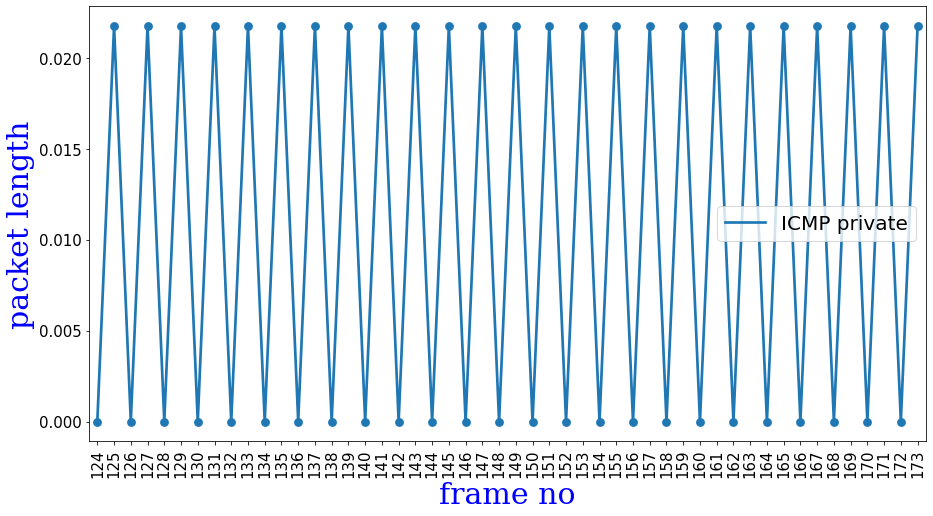

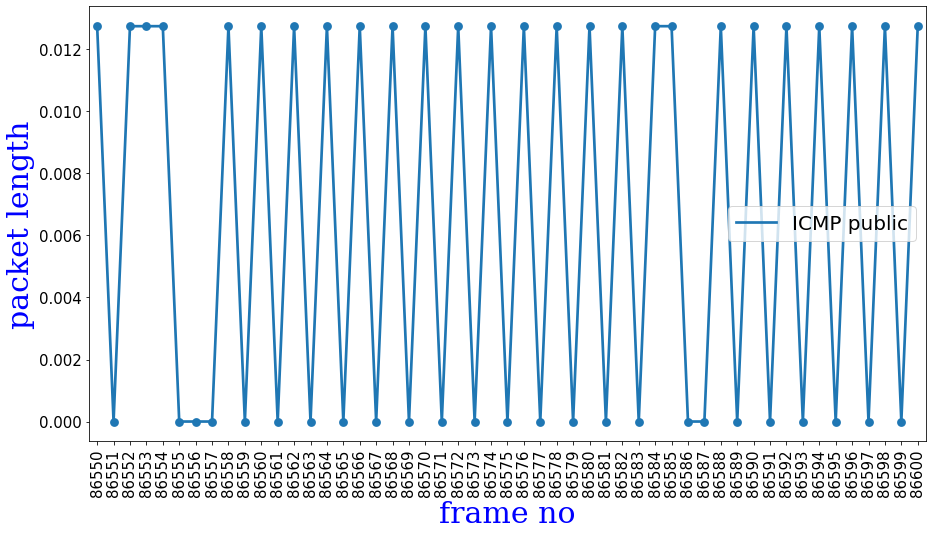

In [141]:
private_ICMP_df = private_ICMP.copy()

# MinMax Scaling
# private data
private_ICMP_df['Length'] = MinMaxScaler().fit_transform(private_ICMP_df.loc[:,['Length']])
public_ICMP['length'] = MinMaxScaler().fit_transform(public_ICMP.loc[:,['length']])

# public_ICMP_first50 = public_ICMP[(public_ICMP['No.'] >= 86550) & (public_ICMP['No.'] < 86601)]
# public_ICMP_last50 = public_ICMP[(public_ICMP['No.'] >= 98149) & (public_ICMP['No.'] < 98199)]

public_ICMP_first50 = public_ICMP[86550:86601]
public_ICMP_last50 = public_ICMP[98149:98199]

# # private data (all data)
# plt.figure(figsize = (15,8))
# sns.pointplot(x=private_ICMP_df.index, y='Length',
#               hue='Protocol', 
#               data=private_ICMP_df)
# plt.xticks(rotation=90)
# plt.xticks(rotation=90)
# plt.title("ICMP attack packet Length Variation (all packets - 1min traffic)", fontdict = font1)

# private data (first 50)
plt.figure(figsize = (15,8))
sns.pointplot(x=private_ICMP_df.index[:50], y='Length',
              hue='Protocol', 
              data=private_ICMP_df[:50])
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('packet length', fontdict = font1)
plt.xlabel('frame no', fontdict = font1)
plt.legend(['ICMP private'], prop={"size":20})
# plt.title("ICMP attack packet Length Variation (first 100 packets - 1min traffic)", fontdict = font1)


# Public ATTACK data 
# first 50 packets
plt.figure(figsize = (15,8))
sns.pointplot(x=public_ICMP_first50.index, y='length',
              hue='protocol', 
              data=public_ICMP_first50
              )
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('packet length', fontdict = font1)
plt.xlabel('frame no', fontdict = font1)
plt.legend(['ICMP public'], prop={"size":20})
# plt.title("ICMP attack packet length Variation (first 50 packets - 1min traffic - [Public])", fontdict = font1)

# # last 50 packets
# plt.figure(figsize = (15,8))
# sns.pointplot(x=public_ICMP_last50.index[:-2], y='length',
#               hue='protocol', 
#               data=public_ICMP_last50[:-2]
#               )
# plt.xticks(rotation=90)
# plt.xticks(rotation=90)
# plt.title("ICMP attack packet length Variation (last 50 packets - 1min traffic - [Public])", fontdict = font1)


# useful codes

In [ ]:
# bool_in = normal_df1.loc[:,'Source'] == '192.168.0.100'
# bool_out = normal_df1.loc[:,'Source'] != '192.168.0.100'
# normal_in_out = round(len(normal_df1[bool_in])/len(normal_df1[bool_out]) * 100)
# normal_in_out
# # 35/29
# len(normal_df1[bool_out])

# bool_in = tcpsyn_df1.loc[:,'Source'] == '192.168.0.100'
# bool_out = tcpsyn_df1.loc[:,'Source'] != '192.168.0.100'
# tcpsyn_in_out = round(len(tcpsyn_df1[bool_in])/len(tcpsyn_df1[bool_out]) * 100, 2)
# # 8083 / 162
# len(tcpsyn_df1[bool_out])

In [ ]:
# normal_df1.Time = pd.to_datetime(normal_df1.Time).dt.time
# np.arange(0, max(normal_df1.Time), 20)
#max(normal_df1.Time) + pd.to_datetime(8)
#(normal_df1.Time) + 19

In [ ]:
# ax.set_xticks(np.arange(0, max(dnsall_df.Time)+19, 20))
# plt.xticks(rotation=45)
# ax.set(xlabel ='Time (min)')
# plt.savefig('plots/plot.png', dpi=300)
# pd.to_timedelta(tcpsyn_df1.Time, unit='s')

In [ ]:
# normal_protocols = {q:p for p,q in enumerate(set(normal_df1.Protocol))}
# tcpsyn_protocols = {q:p for p,q in enumerate(set(tcpsyn_df1.Protocol))}
# print(normal_protocols)
# print(tcpsyn_protocols)

# a = normal_df1.Protocol

# le = LabelEncoder().fit(normal_df1.Protocol) 
# # a = 
# le.transform(normal_df1.Protocol) 

# # le.classes_
# # le.inverse_transform(le.inverse_transform(normal_df1.Protocol)) 

##### Pickle the files

In [ ]:
# # pickle all the file
# import pickle
# # pathlib option
# from pathlib import Path
# basepath = '/content/'
# new_path = 'picked/'
# Path(new_path).mkdir(exist_ok=True)
# for item in Path(basepath).iterdir(): 
#     if item.is_file():  # filter out items that are directories
#         print(item.name)
#         dat = pd.read_csv(item) # read the data for later pickle
#         dat['name'] = item.name[:-4]       # to identify the data later
#         with open(basepath+new_path+item.name[:-4], 'wb') as f:    # save each read data into its file name
#           pickle.dump(dat, f)     # data to dump 
          
# # os option      
# import os
# basepath = '/content/'
# new_path = 'picked444/'
# os.makedirs(basepath+new_path, exist_ok=True) # create the new path if it doesn't exist
# with os.scandir(basepath) as dir_contents:
#   for filename in dir_contents:# returns a list of everything in the specified path
#     if filename.is_file():  # filter out items that are directories
#         print(filename.name)
#         with open(basepath+new_path+filename.name, 'wb') as f:     # files from  
#           pickle.dump(filename.path, f)       # files from 

UDPpublicfiltered.csv
benignprivate.csv
ICMPpublic.csv
TCPSYNprivate.csv
ICMPprivate.csv
TCPSYNpublicfiltered.csv
UDPprivate.csv
benignpublic_somfylock.csv


<AxesSubplot:>

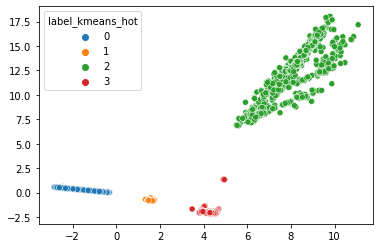

In [224]:
# sns.scatterplot(x = pipe_hot[:,0], y = pipe_hot[:,1], 
#                 hue=y, alpha=None, 
#                 palette= "tab10"
#                )